## **Problem Statement**
The stock market is highly sophisticated, and the investors are faced with a daunting challenge in their pursuit to maximize return and minimize risk. The machine learning project is expected to support the investor to maintain an optimal and diverse investment portfolio in the United Arab Emirates stock markets. The project will also develop a model to predict the future stock close price of DAMAC Properties Dubai Co PSC.

## **Initial Hypotheses**
The objective of this analysis is to provide descriptive and predictive models to maximise returns and minimise risks of investing in the stock markets in the United Arab Emirates. The following hypotheses have been identified and will be tested:

H1: The stocks movements in profoundly impacted by the change of the entire market.<br/>
H2: The stocks in the same industry follow a similar stock movement and direction.<br/>
H3: The return on stocks is higher on the first and last days of the market trading week.<br/>
H4: The return on stocks is lower in the month after summer.

## **Data Preparation**

In [163]:
# Import required packages, libraries and classes for the project
import xgboost
import warnings
import statsmodels.api as sm
import sklearn
import seaborn as sb
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob


from urllib.request import Request, urlopen
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cluster import KMeans
from sklearn. model_selection import cross_val_score
from sklearn. model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics
from scipy.cluster.vq import kmeans,vq
from pylab import rcParams
from pylab import plot,show
from pandas import Series, DataFrame
from numpy.random import rand
from numpy import vstack,array
from matplotlib import pyplot as plt
from math import sqrt
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [323]:
# Set the default inline ploting parameters
%matplotlib inline
rcParams['figure.figsize'] = 20,16
sb.set_style('white')

# Ignore Warning Messages from output
warnings.filterwarnings('ignore')

In [5]:
# Define a Stock List object to collect all the stocks from investing.com
stockList = []

# The Most Active Stocks in the United Arab Emirates are retrieved and collected from investing.com
reqStocks = Request('https://www.investing.com/equities/most-active-stocks?country=dubai', headers={'User-Agent': 'Mozilla/5.0'})
investingWebpage = urlopen(reqStocks).read()
webContent = BeautifulSoup(investingWebpage)
containers = webContent.find_all("td", {'class' : 'left bold plusIconTd elp' })
for table in containers:
    for td in table.findAll('a'):
        url = "https://www.investing.com" + td.get('href')
        req = Request(url, headers = {'User-Agent': 'Mozilla/5.0'})
        webpage = urlopen(req).read()
        content = BeautifulSoup(webpage)
        stock = content.find('h1')
        stockList.append(stock.get_text().replace(")\t", "").split("("))

In [6]:
# Create a Data Frame object from the stockList
stockListDF = pd.DataFrame(stockList)
stockListDF.head()

,0,1,2
0,Emaar Properties PJSC,EMAR,None
1,Dubai Islamic Bank,DISB,None
2,Aldar Properti,ALDAR,None
3,Dana Gas,DANA,None
4,Union Properties PJSC,UPRO,None


In [7]:
# Identify the abnormal entries creating the third column
stockListDF[stockListDF[2].notnull()]

,0,1,2
10,DXB Entertainments,P.J.S.C.),DXBE


In [8]:
# The DXB Entertainments has its (P.J.S.C) in a bracket which defiles the split criteria
# The "P.J.S.C" is appended to "DXB Entertainments" while the symbol "DXBE" is moved to the appriopriate column
stockListDF.iloc[10][0] = stockListDF.iloc[10][0] + stockListDF.iloc[10][1].replace(")", "")
stockListDF.iloc[10][1]  = stockListDF.iloc[10][2]
stockListDF.rename(columns = {0:"Company", 1:"Symbol"}, inplace = True)
stockListDF = stockListDF.drop([2], axis=1)
stockListDF

,Company,Symbol
0,Emaar Properties PJSC,EMAR
1,Dubai Islamic Bank,DISB
2,Aldar Properti,ALDAR
3,Dana Gas,DANA
4,Union Properties PJSC,UPRO
5,Ad Commercial,ADCB
6,First Abu Dhabi Bank PJSC,FAB
7,Dubai Investments PJSC,DINV
8,Deyaar Development PJSC,DEYR
9,Emirate Integrated Telecom Co PJSC,DU


The investing.com platform is not equipped with API and do not support POST or GET request to retrieve historical stock prices through web scrapping conveniently. This project will, therefore, select 20 companies across the various sectors from the active stock list to download the historical stock prices from 1/04/2015 to 31/03/2020 for the data analysis.

<table width="100%">
        <tr>
        <th> <div align="left">SN </div></th>
        <th> <div align="left">Listed Company </div></th>
        <th> <div align="left">Stock Symbol </div></th>
        <th> <div align="left">Sector </div></th>
        </tr>
        <tr>
        <td> <div align="left">1 </div></td>
            <td> <div align="left">Dubai Islamic Bank </div></td>
        <td> <div align="left">DISB </div></td>
        <td> <div align="left">Banking </div></td>
        </tr>
        <tr>
        <td> <div align="left">2 </div></td>
        <td> <div align="left">Emirates NBD PJSC </div></td>
        <td> <div align="left">ENBD </div></td>
        <td> <div align="left">Banking </div></td>
        </tr>
        <tr>
        <td> <div align="left">3 </div></td>
        <td> <div align="left">Ajman Bank PJSC </div></td>
        <td> <div align="left">AJBNK </div></td>
        <td> <div align="left">Banking </div></td>
        </tr>
        <tr>
        <td> <div align="left">4 </div></td>
        <td> <div align="left">Al Salam Bank </div></td>
        <td> <div align="left">SALAM </div></td>
        <td> <div align="left">Banking </div></td>
        </tr>
        <tr>
          <td><div align="left">5</div></td>
          <td><div align="left">Emaar Properties PJSC</div></td>
          <td><div align="left">EMAR</div></td>
          <td><div align="left">Real Estate</div></td>
        </tr>
        <tr>
          <td><div align="left">6</div></td>
          <td><div align="left">Union Properties PJSC</div></td>
          <td><div align="left">UPRO</div></td>
          <td><div align="left">Real Estate</div></td>
        </tr>
        <tr>
          <td><div align="left">7</div></td>
          <td><div align="left">Damac Properties Dubai Co PSC</div></td>
          <td><div align="left">DAMAC</div></td>
          <td><div align="left">Real Estate</div></td>
        </tr>
        <tr>
          <td><div align="left">8</div></td>
          <td><div align="left">Deyaar Development PJSC</div></td>
          <td><div align="left">DEYR</div></td>
          <td><div align="left">Real Estate</div></td>
        </tr>
        <tr>
          <td><div align="left">9</div></td>
          <td><div align="left">Dubai Investments PJSC</div></td>
          <td><div align="left">DINV</div></td>
          <td><div align="left">Investment and Financial Services</div></td>
        </tr>
        <tr>
          <td><div align="left">10</div></td>
          <td><div align="left">Dubai Financial Market PJSC</div></td>
          <td><div align="left">DFM</div></td>
          <td><div align="left">Investment and Financial Services</div></td>
        </tr>
        <tr>
          <td><div align="left">11</div></td>
          <td><div align="left">Ekttitab Holding Co. KSCC</div></td>
          <td><div align="left">EKTT</div></td>
          <td><div align="left">Investment and Financial Services</div></td>
        </tr>
        <tr>
          <td><div align="left">12</div></td>
          <td><div align="left">SHUAA Capital PSC</div></td>
          <td><div align="left">SHUA</div></td>
          <td><div align="left">Investment and Financial Services</div></td>
        </tr>
        <tr>
          <td><div align="left">13</div></td>
          <td><div align="left">Islamic Arab Insurance Company</div></td>
          <td><div align="left">SALAMA</div></td>
          <td><div align="left">Insurance</div></td>
        </tr>
        <tr>
          <td><div align="left">14</div></td>
          <td><div align="left">Dubai Islamic Insurance Co.</div></td>
          <td><div align="left">AMAN</div></td>
          <td><div align="left">Insurance</div></td>
        </tr>
        <tr>
          <td><div align="left">15</div></td>
          <td><div align="left">ARAMEX PJSC</div></td>
          <td><div align="left">ARMX</div></td>
          <td><div align="left">Transportation</div></td>
        </tr>
        <tr>
          <td><div align="left">16</div></td>
          <td><div align="left">Air Arabia PJSC</div></td>
          <td><div align="left">AIRA</div></td>
          <td><div align="left">Transportation</div></td>
        </tr>
        <tr>
          <td><div align="left">17</div></td>
          <td><div align="left">Emirate Integrated Telecom Co PJSC</div></td>
          <td><div align="left">DU</div></td>
          <td><div align="left">Telecommunication</div></td>
        </tr>
         <tr>
          <td><div align="left">18</div></td>
          <td><div align="left">DXB Entertainments P.J.S.C.</div></td>
          <td><div align="left">DXBE</div></td>
          <td><div align="left">Consumer Staples and Discretionary</div></td>
        </tr>
         <tr>
          <td><div align="left">19</div></td>
          <td><div align="left">Amanat Holdings PJSC</div></td>
          <td><div align="left">AMANT</div></td>
          <td><div align="left">Healthcare and Education Investment </div></td>
        </tr>
        <tr>
          <td><div align="left">20</div></td>
          <td><div align="left">Arabtec Holding PJSC</div></td>
          <td><div align="left">ARTC</div></td>
          <td><div align="left">Construction</div></td>
        </tr>
    </table>
    
    

In [9]:
# Define the host directory for all the historic stock prices csv files and the applicable extension to load into the list object 
directory =r'C:\sandbox\Python\Investors'
filenames = glob.glob(directory + "/*.csv")

# Collect all the historic stock prices into a list object and subsequently into the stockDF Data Frame
reader = []
for filename in filenames:
    reader.append(pd.read_csv(filename))

stockDF = pd.concat(reader, ignore_index=True)

In [10]:
# Display the top 5 observations to confirm that the Stock Dataset is loaded successfully
stockDF.head()

,Date,Symbol,Price,Open,High,Low,Vol.,Change %
0,31-Mar-20,AIRA,0.951,0.940,0.960,0.940,5.28M,1.17%
1,30-Mar-20,AIRA,0.940,0.969,0.969,0.938,3.56M,0.00%
2,29-Mar-20,AIRA,0.940,0.950,0.955,0.933,2.37M,-3.59%
3,26-Mar-20,AIRA,0.975,0.980,0.980,0.950,6.70M,1.56%
4,25-Mar-20,AIRA,0.960,0.910,0.980,0.890,12.78M,9.71%


In [11]:
# Use string replace and map function to convert the "M" and "K" to "1000000" and "1000" respectively
stockDF['Vol.'] = stockDF['Vol.'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)
stockDF['Vol.'] = pd.to_numeric(stockDF['Vol.'])

In [12]:
# Convert the Date feature to a datetime datatype
stockDF['Date'] = pd.to_datetime(stockDF['Date'])

In [13]:
# Rename the features and display the top 5 observations to confirm the changes to "Vol." and "Date" features of the Stock Dataset
stockDF.rename(columns = {"Price":"Close", "Vol.":"Volume", "Change %":"Change"}, inplace = True)
stockDF.head()

,Date,Symbol,Close,Open,High,Low,Volume,Change
0,2020-03-31,AIRA,0.951,0.940,0.960,0.940,5280000,1.17%
1,2020-03-30,AIRA,0.940,0.969,0.969,0.938,3560000,0.00%
2,2020-03-29,AIRA,0.940,0.950,0.955,0.933,2370000,-3.59%
3,2020-03-26,AIRA,0.975,0.980,0.980,0.950,6700000,1.56%
4,2020-03-25,AIRA,0.960,0.910,0.980,0.890,12780000,9.71%


In [35]:
# Extract the Dates, Symbols and Close Stocks' Values of all the 20 listed companies from stockDF Data Frame and restructure the table in stockDFClose Data Frame.
stockDFClose = stockDF[["Date", "Symbol", "Close"]]
stockDFClose = pd.pivot_table(stockDFClose,index='Date',columns='Symbol',values='Close')
stockDFClose = stockDFClose.reset_index()

# Display the Top 5 Observations to confirm that the stockDFClose Data Frame is structured properly
stockDFClose.head()

Symbol,Date,AIRA,AJBNK,AMAN,AMANT,ARMX,ARTC,DAMAC,DEYR,DFM,...,DISB,DU,DXBE,EKTT,EMAR,ENBD,SALAM,SALAMA,SHUA,UPRO
0,2015-04-01,1.41,1.729,0.648,0.819,3.35,2.181,1.89,0.621,1.51,...,5.687,4.90,0.880,0.489,6.64,NaN,1.07,0.490,0.610,0.857
1,2015-04-02,1.42,1.706,0.635,0.825,3.43,2.295,2.04,0.653,1.59,...,5.742,4.98,0.880,0.490,7.06,9.1,1.14,0.491,0.669,0.887
2,2015-04-05,1.44,1.706,0.630,0.847,3.47,2.371,2.20,0.666,1.67,...,5.815,5.00,0.896,0.485,7.09,NaN,1.16,0.502,0.669,0.899
3,2015-04-06,1.45,1.713,0.680,0.832,3.39,2.400,2.35,0.695,1.74,...,5.879,4.95,0.898,0.444,7.21,9.0,1.20,0.525,0.680,0.970
4,2015-04-07,1.47,1.839,0.690,0.856,3.50,2.476,2.35,0.725,1.82,...,5.998,5.00,0.885,0.477,7.25,9.0,1.25,0.540,0.710,0.979


In [36]:
# Set the Date Feature as the index for the stockDFClose Data Frame
stockDFClose = stockDFClose.set_index("Date")

In [37]:
# Review the summary of the stockDFClose Data Frame to determine if there are missing values or irregular entries.
stockDFClose.describe()

Symbol,AIRA,AJBNK,AMAN,AMANT,ARMX,ARTC,DAMAC,DEYR,DFM,DINV,DISB,DU,DXBE,EKTT,EMAR,ENBD,SALAM,SALAMA,SHUA,UPRO
count,1251.000000,1209.000000,1142.000000,1219.000000,1245.000000,1249.000000,1251.000000,1250.000000,1251.000000,1251.000000,1250.000000,1246.000000,1250.000000,1060.000000,1250.000000,1168.000000,1194.000000,1251.000000,1241.000000,1247.000000
mean,1.233830,1.226512,0.645007,1.004386,4.015301,3.848131,2.284898,0.504683,1.153861,1.940952,5.279654,5.468708,0.750135,0.372701,6.057228,9.285375,0.979580,0.505030,0.941777,0.690599
std,0.190104,0.329782,0.169655,0.202847,0.668126,2.554258,0.914084,0.138446,0.327098,0.476164,0.485266,0.511342,0.466172,0.117845,1.447611,1.576211,0.158145,0.083062,0.341047,0.256071
min,0.875000,0.515000,0.300000,0.577000,2.010000,0.441000,0.366000,0.186000,0.501000,0.982000,3.600000,4.500000,0.095000,0.124000,1.990000,6.430000,0.644000,0.303000,0.319000,0.163000
25%,1.060000,0.929000,0.503000,0.840000,3.470000,1.970000,1.500000,0.377000,0.908500,1.400000,4.980000,5.060000,0.262000,0.284250,4.882500,8.150000,0.880250,0.448500,0.666000,0.414000
50%,1.230000,1.150000,0.633500,0.970000,4.050000,2.710000,2.390000,0.507500,1.120000,2.000000,5.220000,5.320000,0.752000,0.403500,6.140000,8.762000,0.929000,0.490000,0.959000,0.711000
75%,1.360000,1.520000,0.736750,1.140000,4.380000,5.865000,2.880000,0.591000,1.300000,2.322000,5.493000,5.850000,1.136000,0.450000,7.287500,10.000000,1.050000,0.560000,1.110000,0.896500
max,1.690000,1.996000,1.180000,1.510000,5.500000,12.921000,4.430000,0.930000,2.200000,2.981000,7.002000,6.930000,1.760000,0.630000,8.930000,13.900000,1.500000,0.739000,1.930000,1.261000


In [38]:
# Imputate the missing values, which are days when the stocks were not traded. 
# The imputation methodology is to use either the stock close value of the day before or the day after.
while stockDFClose.isnull().values.any():
    stockDFClose = stockDFClose.fillna(stockDFClose.shift())
    stockDFClose = stockDFClose.fillna(stockDFClose.shift(-1))
stockDFClose.describe()

Symbol,AIRA,AJBNK,AMAN,AMANT,ARMX,ARTC,DAMAC,DEYR,DFM,DINV,DISB,DU,DXBE,EKTT,EMAR,ENBD,SALAM,SALAMA,SHUA,UPRO
count,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000
mean,1.233830,1.223951,0.638120,1.005893,4.015540,3.847062,2.284898,0.504655,1.153861,1.940952,5.279462,5.467010,0.749735,0.359756,6.058541,9.236274,0.980936,0.505030,0.941961,0.689720
std,0.190104,0.330239,0.166241,0.201670,0.666979,2.552394,0.914084,0.138394,0.327098,0.476164,0.485119,0.511064,0.466201,0.120758,1.447777,1.544712,0.157691,0.083062,0.339819,0.256723
min,0.875000,0.515000,0.300000,0.577000,2.010000,0.441000,0.366000,0.186000,0.501000,0.982000,3.600000,4.500000,0.095000,0.124000,1.990000,6.430000,0.644000,0.303000,0.319000,0.163000
25%,1.060000,0.925000,0.500500,0.840000,3.475000,1.970000,1.500000,0.377000,0.908500,1.400000,4.980000,5.060000,0.261000,0.246500,4.885000,8.150000,0.881000,0.448500,0.668000,0.412000
50%,1.230000,1.150000,0.629000,0.972000,4.050000,2.720000,2.390000,0.507000,1.120000,2.000000,5.220000,5.310000,0.752000,0.381000,6.140000,8.680000,0.930000,0.490000,0.960000,0.711000
75%,1.360000,1.520000,0.714000,1.140000,4.380000,5.865000,2.880000,0.591000,1.300000,2.322000,5.493000,5.850000,1.136000,0.446000,7.290000,9.979000,1.060000,0.560000,1.110000,0.896500
max,1.690000,1.996000,1.180000,1.510000,5.500000,12.921000,4.430000,0.930000,2.200000,2.981000,7.002000,6.930000,1.760000,0.630000,8.930000,13.900000,1.500000,0.739000,1.930000,1.261000


In [674]:
# Extract the DAMAC Stock histrory from the stockDF Data Frame into stockDAMAC Data Frame for Predictive Analysis
stockDAMAC = stockDF[stockDF['Symbol'] == "DAMAC"]

stockDAMACClose = stockDAMAC[["Date", "Close"]]
stockDAMACClose = stockDAMACClose.set_index("Date")

In [675]:
# Display the Top 5 Observations to confirm that the stockDAMAC Data Frame is extracted successfully
stockDAMAC.head()

,Date,Symbol,Close,Open,High,Low,Volume,Change
7315,2020-03-31,DAMAC,0.484,0.475,0.484,0.471,625460,0.62%
7316,2020-03-30,DAMAC,0.481,0.490,0.490,0.475,3660000,-3.80%
7317,2020-03-29,DAMAC,0.500,0.481,0.520,0.475,4130000,3.95%
7318,2020-03-26,DAMAC,0.481,0.498,0.499,0.481,4000000,-2.83%
7319,2020-03-25,DAMAC,0.495,0.450,0.499,0.445,13430000,14.06%


In [676]:
# Feature Engineering -  Create new features from the Date as critical components of the technical analysis. 
# The features are created in line with the initial hypotheses and relevant attributes in the stock market technical analysis.
# Year = The year (2015 - 2020) of the close stock value
# Month = The month (1 - January - 12 December) of the close stock value
# Day = The day (1 - 31) of the close stock value
# DofWeek = The day of the week (0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday, 4: Friday, 5: Saturday and 6: Sunday) of the close stock value
# MarketOC = Is the Market Open Day of the Week (6: Sunday) or Market CLose Day of the Week (3: Thursday)
# startMonth = Is the day of the close stock value the start of the month (1: Yes, 0: No)
# endMonth = Is the day of the close stock value the end of the month (1: Yes, 0: No)
# startYear = Is the day of the close stock value the start of the year (1: Yes, 0: No)
# endYear = Is the day of the close stock value the end of the year (1: Yes, 0: No)
# startQuarter = Is the day of the close stock value the start of the quarter (1: Yes, 0: No)
# endQuarter = Is the day of the close stock value the end of the quarter (1: Yes, 0: No)
# isSummer = Is the day of the close stock in September which is considered the end of summer (1: Yes, 0: No)
# Quarter = The Quarter (1 - 4) of the close stock value
stockDAMAC["Date"] = pd.to_datetime(stockDAMAC["Date"])
stockDAMAC['Year'] = stockDAMAC['Date'].dt.year
stockDAMAC["Month"] = stockDAMAC['Date'].dt.month
stockDAMAC["Day"] = stockDAMAC['Date'].dt.day
stockDAMAC['DofWeek'] = stockDAMAC['Date'].dt.dayofweek
stockDAMAC['MarketOC'] = np.where(stockDAMAC['DofWeek'].isin([6,3]),1,0)
stockDAMAC['startMonth'] = np.where(stockDAMAC['Date'].dt.is_month_start,1,0)
stockDAMAC['endMonth'] = np.where(stockDAMAC['Date'].dt.is_month_end,1,0)
stockDAMAC['startYear'] = np.where(stockDAMAC['Date'].dt.is_year_start,1,0)
stockDAMAC['endYear'] = np.where(stockDAMAC['Date'].dt.is_year_end,1,0)
stockDAMAC['isSummer'] = np.where(stockDAMAC['Month'].isin([9]),1,0)
stockDAMAC['startQuarter'] = np.where(stockDAMAC['Date'].dt.is_quarter_start,1,0)
stockDAMAC['endQuarter'] =  np.where(stockDAMAC['Date'].dt.is_quarter_end,1,0)
stockDAMAC['Quarter'] = stockDAMAC['Date'].dt.quarter

# The features that are irrelevant to the technical analysis are dropped from the stockDAMAC Data Frame 
stockDAMAC = stockDAMAC.drop(['Date','Symbol', 'Open', 'High', 'Low', 'Volume', 'Change'], axis=1)
stockDAMAC = stockDAMAC.reset_index(drop=True)

In [677]:
# Display the Top 5 Observations to confirm that the new features are appended to the stockDAMAC Data Frame successfully
stockDAMAC.head()

,Close,Year,Month,Day,DofWeek,MarketOC,startMonth,endMonth,startYear,endYear,isSummer,startQuarter,endQuarter,Quarter
0,0.484,2020,3,31,1,0,0,1,0,0,0,0,1,1
1,0.481,2020,3,30,0,0,0,0,0,0,0,0,0,1
2,0.500,2020,3,29,6,1,0,0,0,0,0,0,0,1
3,0.481,2020,3,26,3,1,0,0,0,0,0,0,0,1
4,0.495,2020,3,25,2,0,0,0,0,0,0,0,0,1


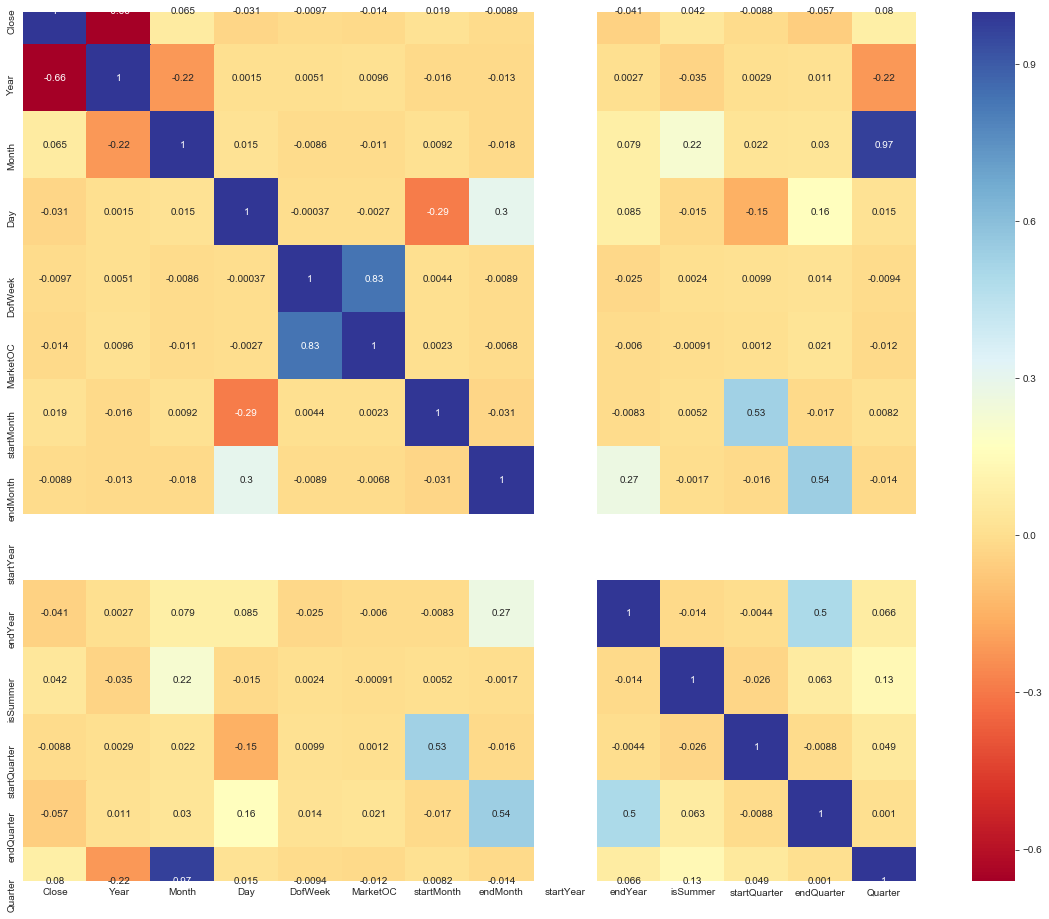

In [678]:
# Check the multicollinearity of the features in the stockDAMAC Data Frame
corrmatrix = stockDAMAC.corr()
high_corr_features = corrmatrix.index
sb.heatmap(stockDAMAC[high_corr_features].corr(),annot = True, cmap = "RdYlBu")

The multicollinearity check shows that Quarter and Month are highly correlated (97%), likewise the DofWeek (Days of the Week) and MarketOC (Market Week Open and Market Week Close) are also highly correlated (83%). The Quater and DofWeek features will be dropped. The MarketOC, as well as Month features, will be retained as they form part of the core hypotheses of the project.

In [679]:
# Eliminate the Quarter and DofWeek features from the stockDAMAC Data Frame
stockDAMAC = stockDAMAC.drop(['Quarter','DofWeek'], axis=1)
stockDAMAC = stockDAMAC.reset_index(drop=True)

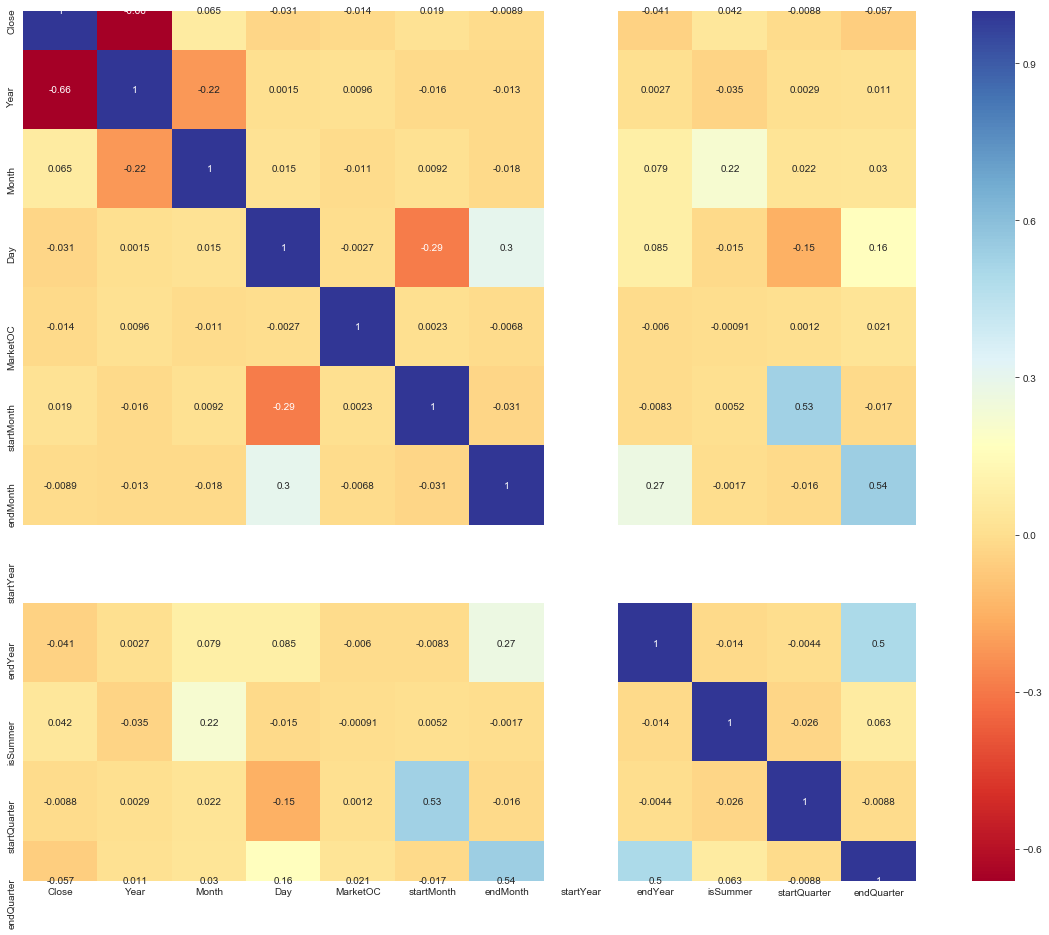

In [680]:
# Re-evalate the multicollinearity of the features in the stockDAMAC Data Frame after the removal of Quarter and DofWeek
corrmatrix = stockDAMAC.corr()
high_corr_features = corrmatrix.index
sb.heatmap(stockDAMAC[high_corr_features].corr(),annot = True, cmap = "RdYlBu")

In [681]:
# Display the Top 5 Observations to confirm that the removed features have been dropped from stockDAMAC Data Frame successfully.
stockDAMAC.head()

,Close,Year,Month,Day,MarketOC,startMonth,endMonth,startYear,endYear,isSummer,startQuarter,endQuarter
0,0.484,2020,3,31,0,0,1,0,0,0,0,1
1,0.481,2020,3,30,0,0,0,0,0,0,0,0
2,0.500,2020,3,29,1,0,0,0,0,0,0,0
3,0.481,2020,3,26,1,0,0,0,0,0,0,0
4,0.495,2020,3,25,0,0,0,0,0,0,0,0


## **Exploratory Data Analysis**

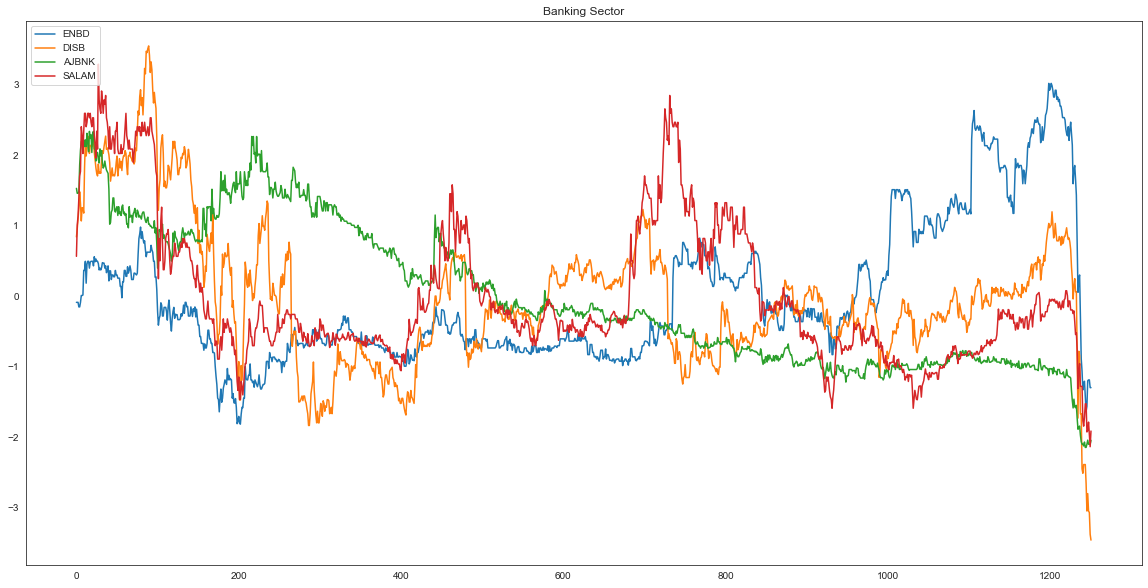

In [325]:
# Plot the Close Stock Price for the Banking Sector: ENBD | DISB | AJBNK | SALAM for the five years period.
plt.figure(figsize=(20,10))
plt.plot(stockDFClose["ENBD"], label = "ENBD")
plt.plot(stockDFClose["DISB"], label = "DISB")
plt.plot(stockDFClose["AJBNK"], label = "AJBNK")
plt.plot(stockDFClose["SALAM"], label = "SALAM")
plt.title("Banking Sector")
plt.legend(loc='upper left')
plt.show()

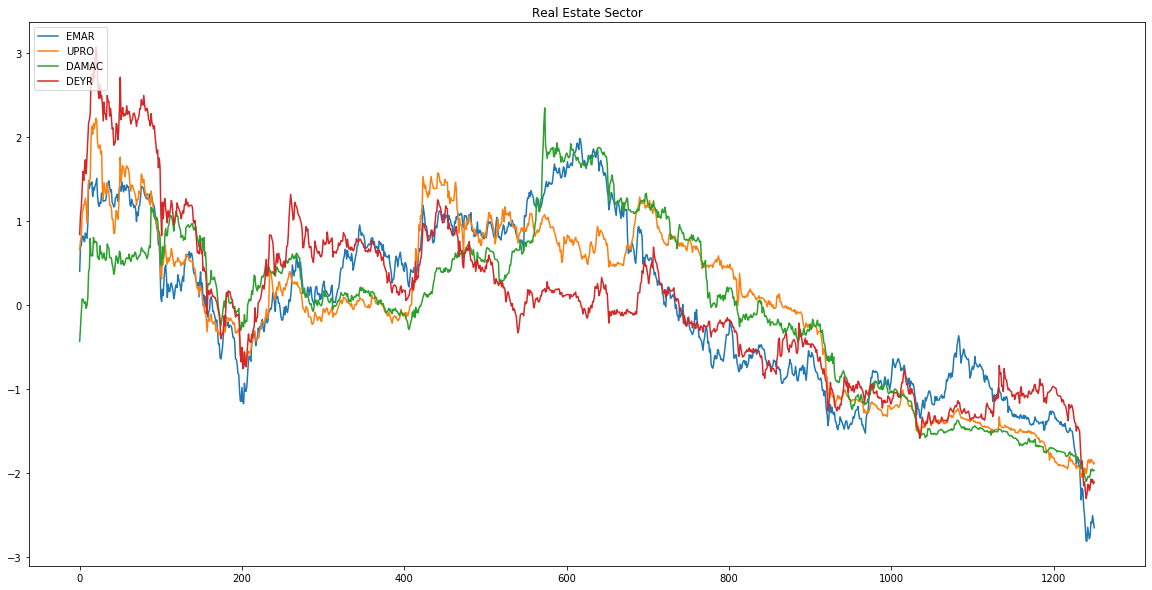

In [138]:
# Plot the Close Stock Price for the Real Estate Sector: EMAR | UPRO | DAMAC | DEYR for the five years period.
plt.figure(figsize=(20,10))
plt.plot(stockDFClose["EMAR"], label = "EMAR")
plt.plot(stockDFClose["UPRO"], label = "UPRO")
plt.plot(stockDFClose["DAMAC"], label = "DAMAC")
plt.plot(stockDFClose["DEYR"], label = "DEYR")
plt.title("Real Estate Sector")
plt.legend(loc='upper left')
plt.show()

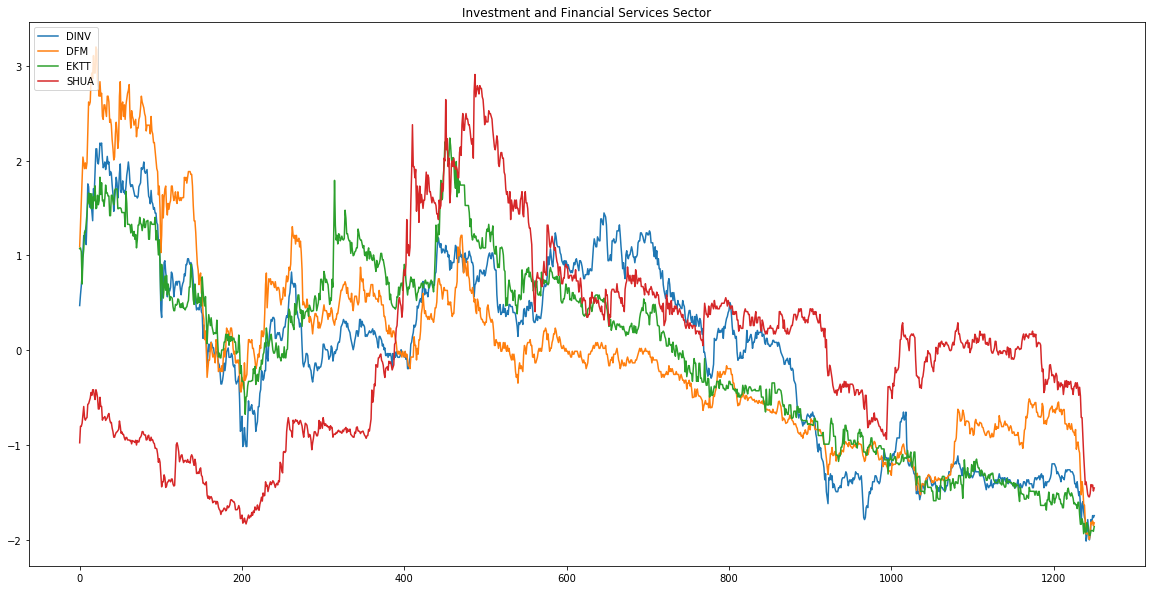

In [139]:
# Plot the Close Stock Price for the Investment and Financial Services Sector: DINV | DFM | EKTT | SHUA for the five years period.
plt.figure(figsize=(20,10))
plt.plot(stockDFClose["DINV"], label = "DINV")
plt.plot(stockDFClose["DFM"], label = "DFM")
plt.plot(stockDFClose["EKTT"], label = "EKTT")
plt.plot(stockDFClose["SHUA"], label = "SHUA")
plt.title("Investment and Financial Services Sector")
plt.legend(loc='upper left')
plt.show()

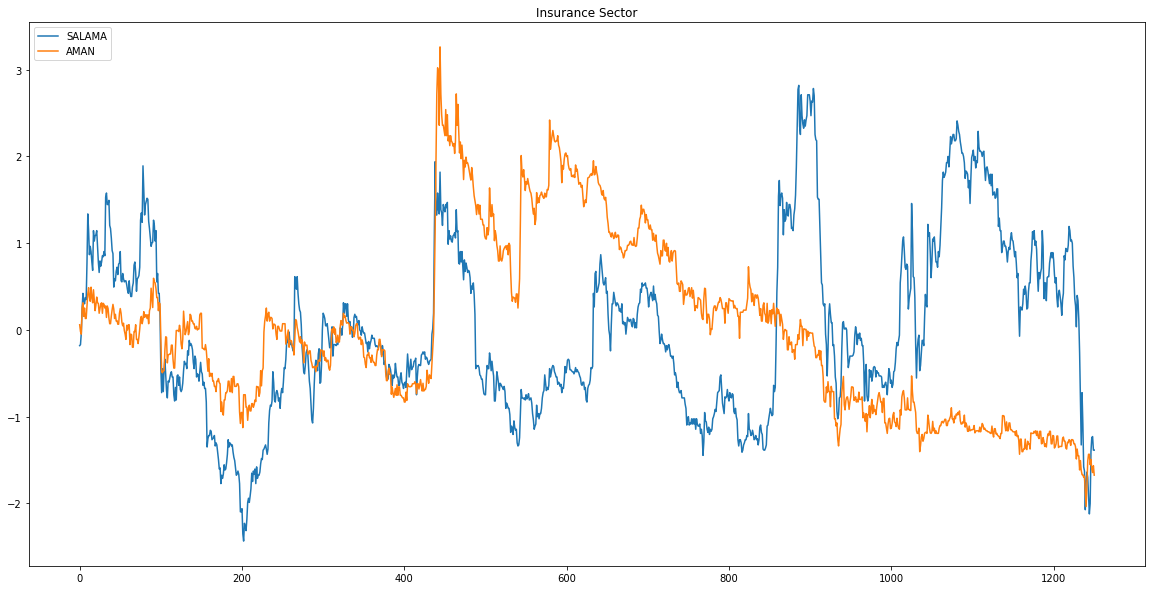

In [140]:
# Plot the Close Stock Price for the Insurance Sector: SALAMA | AMAN for the five years period.
plt.figure(figsize=(20,10))
plt.plot(stockDFClose["SALAMA"], label = "SALAMA")
plt.plot(stockDFClose["AMAN"], label = "AMAN")
plt.title("Insurance Sector")
plt.legend(loc='upper left')
plt.show()

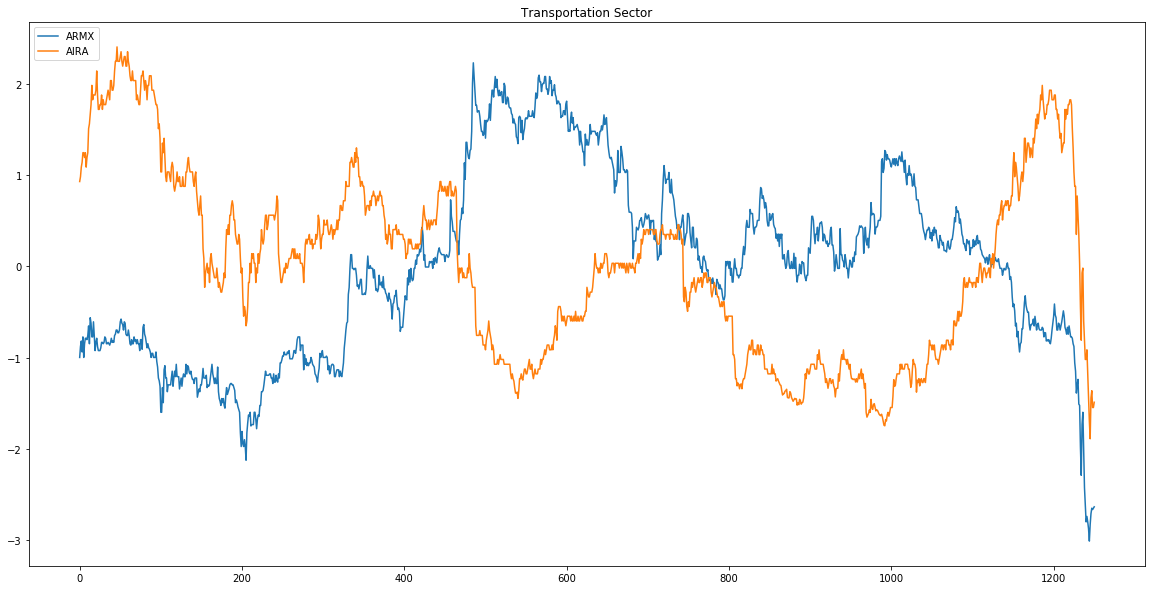

In [141]:
# Plot the Close Stock Price for the Transportation Sector: ARMX | AIRA for the five years period.
plt.figure(figsize=(20,10))
plt.plot(stockDFClose["ARMX"], label = "ARMX")
plt.plot(stockDFClose["AIRA"], label = "AIRA")
plt.title("Transportation Sector")
plt.legend(loc='upper left')
plt.show()

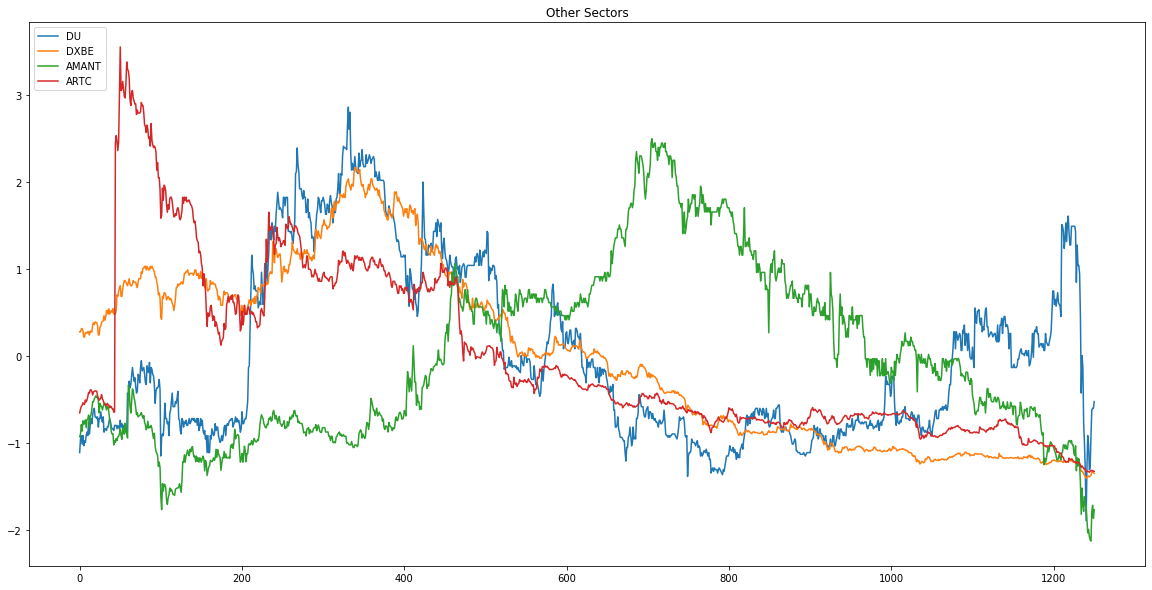

In [142]:
# Plot the Close Stock Price for the Mixed Sectors: DU (Telecommunication) | DXBE (Consumer Staples and Discretionary) | AMANT (Healthcare and Education) | ARTC (Construction) for the five years period.
plt.figure(figsize=(20,10))
plt.plot(stockDFClose["DU"], label = "DU")
plt.plot(stockDFClose["DXBE"], label = "DXBE")
plt.plot(stockDFClose["AMANT"], label = "AMANT")
plt.plot(stockDFClose["ARTC"], label = "ARTC")
plt.title("Other Sectors")
plt.legend(loc='upper left')
plt.show()

## **Final Hypotheses**

With the preliminary review of the dataset, data preprocessing, and exploratory data analysis, the initial hypotheses will be considered and validated. The hypotheses for this machine learning project are as follows:<br/>
H1: The stocks movements in profoundly impacted by the change of the entire market.<br/>
H2: The stocks in the same industry follow a similar stock movement and direction.<br/>
H3: The return on stocks is higher on the first and last days of the market trading week.<br/>
H4: The return on stocks is lower in the month after summer.

### Descriptive Model
The objective of the descriptive model of this machine learning project is to provide the investors with the optimal portfolio mix to maximise return and minimise risk. The K-Means algorithm is adopted in this case based on the inference from the literature review that postulates that the K-Means tends to perform better than its alternatives, in terms of scalability and efficiency, especially for stocks' classification. The unsupervised classification observes the similarity of the shares based on the stock movement leveraging the volatility and return.

In [466]:
# Scale the stockDFClose Dataframe and complete the standadisation process
stockDFClose = pd.DataFrame(StandardScaler().fit_transform(stockDFClose), columns = stockDFClose.columns)
stockDFClose.head()

Symbol,AIRA,AJBNK,AMAN,AMANT,ARMX,ARTC,DAMAC,DEYR,DFM,DINV,DISB,DU,DXBE,EKTT,EMAR,ENBD,SALAM,SALAMA,SHUA,UPRO
0,0.927076,1.529953,0.059456,-0.927095,-0.998240,-0.653006,-0.432188,0.841015,1.089221,0.470715,0.840414,-1.109915,0.279530,1.070697,0.401782,-0.088255,0.565027,-0.181016,-0.977268,0.651857
1,0.979700,1.460279,-0.018775,-0.897331,-0.878249,-0.608324,-0.268024,1.072332,1.333894,0.584167,0.953834,-0.953316,0.279530,1.078982,0.691998,-0.088255,1.009110,-0.168972,-0.803576,0.768761
2,1.084948,1.460279,-0.048864,-0.788199,-0.818253,-0.578536,-0.092915,1.166304,1.578567,0.678710,1.104372,-0.914166,0.313864,1.037560,0.712728,-0.088255,1.135990,-0.036488,-0.803576,0.815523
3,1.137572,1.481484,0.252025,-0.862607,-0.938244,-0.567169,0.071249,1.375935,1.792656,0.792162,1.236351,-1.012041,0.318156,0.697903,0.795647,-0.153018,1.389752,0.240523,-0.771193,1.092197
4,1.242819,1.863178,0.312203,-0.743554,-0.773256,-0.537382,0.071249,1.592795,2.037329,1.037974,1.481750,-0.914166,0.290260,0.971285,0.823287,-0.153018,1.706954,0.421183,-0.682875,1.127268


In [476]:
# Review the summary of the stockDFClose Data Frame after the scaling
stockDFClose.describe()

Symbol,AIRA,AJBNK,AMAN,AMANT,ARMX,ARTC,DAMAC,DEYR,DFM,DINV,DISB,DU,DXBE,EKTT,EMAR,ENBD,SALAM,SALAMA,SHUA,UPRO
count,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03,1.251000e+03
mean,-6.281502e-16,-1.277955e-17,-5.983312e-16,-3.258784e-16,-3.755766e-16,9.655657e-17,-1.206957e-17,1.029463e-17,-1.207312e-15,1.133297e-15,9.762153e-17,-1.922257e-16,-5.862617e-16,9.857999e-16,-9.030879e-16,-1.450478e-15,4.346820e-16,2.105075e-16,3.441603e-16,5.839542e-17
std,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00,1.000400e+00
min,-1.888301e+00,-2.147638e+00,-2.034733e+00,-2.127552e+00,-3.008101e+00,-1.334991e+00,-2.100097e+00,-2.303451e+00,-1.996719e+00,-2.014718e+00,-3.463342e+00,-1.892909e+00,-1.404965e+00,-1.953080e+00,-2.811323e+00,-1.817424e+00,-2.137536e+00,-2.433241e+00,-1.833949e+00,-2.052528e+00
25%,-9.147594e-01,-9.056181e-01,-8.281671e-01,-8.229229e-01,-8.107533e-01,-7.357061e-01,-8.590152e-01,-9.227777e-01,-7.504153e-01,-1.136517e+00,-6.175427e-01,-7.967171e-01,-1.048753e+00,-9.382507e-01,-8.109056e-01,-7.035025e-01,-6.339976e-01,-6.808413e-01,-8.065199e-01,-1.082222e+00
50%,-2.015356e-02,-2.240217e-01,-5.488163e-02,-1.681280e-01,5.168707e-02,-4.417469e-01,1.150261e-01,1.694776e-02,-1.035607e-01,1.240573e-01,-1.226210e-01,-3.073456e-01,4.861191e-03,1.759905e-01,5.628727e-02,-3.602592e-01,-3.231395e-01,-1.810160e-01,5.310594e-02,8.292321e-02
75%,6.639568e-01,8.968256e-01,4.566301e-01,6.652474e-01,5.466528e-01,7.909222e-01,6.512960e-01,6.241550e-01,4.469539e-01,8.005657e-01,4.403524e-01,7.496967e-01,8.288690e-01,7.144714e-01,8.509261e-01,4.810107e-01,5.015861e-01,6.620629e-01,4.946946e-01,8.057812e-01
max,2.400545e+00,2.338780e+00,3.260918e+00,2.500658e+00,2.226537e+00,3.556491e+00,2.347660e+00,3.074670e+00,3.199527e+00,2.185097e+00,3.552172e+00,2.863781e+00,2.167882e+00,2.238787e+00,1.984150e+00,3.020364e+00,3.292965e+00,2.817936e+00,2.908712e+00,2.226168e+00


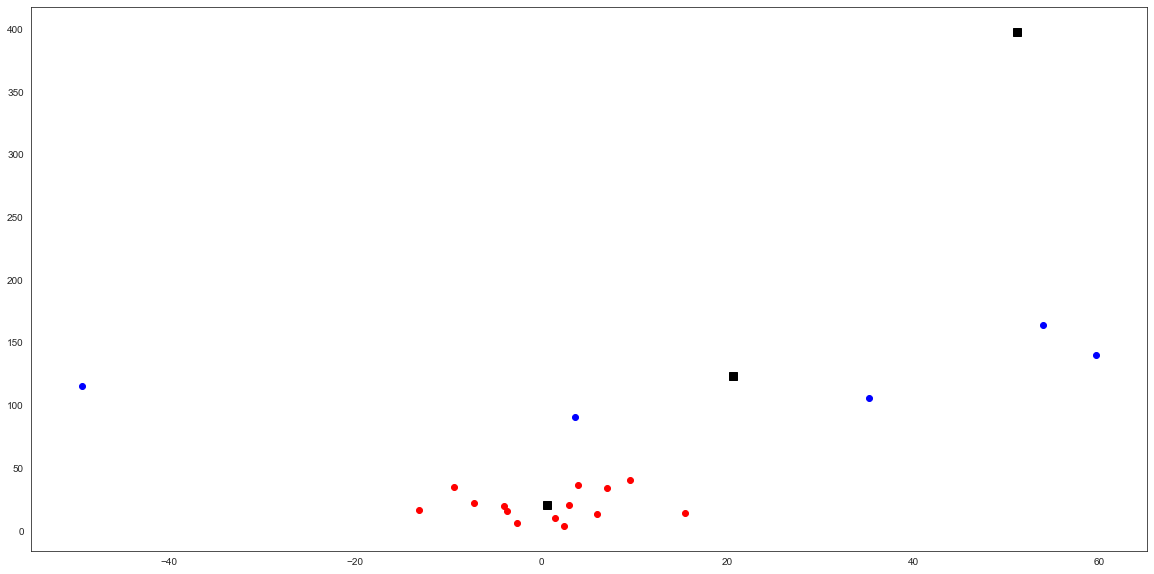

In [511]:
# Calculate the average annual percentage of the stock returns as well as the volatility of the stocks over an average of 250 market trading days in the UAE per year
stockReturns = stockDFClose.pct_change().mean() * 250
stockReturns = pd.DataFrame(stockReturns)
stockReturns.columns = ['Returns']
stockReturns['Volatility'] = stockDFClose.pct_change().std() * sqrt(250)

# Convert the stockReturns Dataframe to numpy array and transpose the array to a return and volatility pair for the K-Means Clustering Algorithm
stockX = np.asarray([np.asarray(stockReturns['Returns']),np.asarray(stockReturns['Volatility'])]).T

# Execute the K-Means Algorithm with the value of K=3
centroids,_ = kmeans(stockX,3)

# Assign each of the stock to a cluster
idx,_ = vq(stockX,centroids)

# Plot the cluster indices of each of the stock using the logical indexing from numpy
plt.figure(figsize=(20,10))
plt.plot(stockX[idx==0,0],stockX[idx==0,1],'ob',
     stockX[idx==1,0],stockX[idx==1,1],'oy',
     stockX[idx==2,0],stockX[idx==2,1],'or')
plt.plot(centroids[:,0],centroids[:,1],'sk', markersize=8)
plt.show()

In [512]:
# Print out the stocks with the clusters they belong based on the K-Means Algorithm
stockClusters = [(name,cluster) for name, cluster in zip(stockReturns.index,idx)]

for stockPoint in stockClusters:
    print(stockPoint)

('AIRA', 2)
('AJBNK', 2)
('AMAN', 0)
('AMANT', 2)
('ARMX', 2)
('ARTC', 2)
('DAMAC', 2)
('DEYR', 2)
('DFM', 2)
('DINV', 2)
('DISB', 0)
('DU', 2)
('DXBE', 2)
('EKTT', 2)
('EMAR', 0)
('ENBD', 2)
('SALAM', 2)
('SALAMA', 1)
('SHUA', 0)
('UPRO', 0)


<table width="100%">
  <tr>
    <th width="100"> <div align="left">Clusters </div></th>
    <th width="300"> <div align="left">Listed Company </div></th>
    <th width="120"> <div align="left">Stock Symbol </div></th>
    <th width="250"> <div align="left">Sector </div></th>
  </tr>
  <tr>
    <td><div align="left">Cluster 1</div></td>
    <td><div align="left">Islamic Arab Insurance Company</div></td>
    <td><div align="left">SALAMA</div></td>
    <td><div align="left">Insurance</div></td>
  </tr>
  <tr>
    <td rowspan="14" align="right" bgcolor="#FFFFCC"><div align="left">Cluster 2</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Air Arabia PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">AIRA</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Transportation</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Ajman Bank PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">AJBNK</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Banking</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Amanat Holdings PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">AMANT</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Healthcare and Education    Investment</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">ARAMEX PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">ARMX</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Transportation</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Arabtec Holding PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">ARTC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Construction</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Damac Properties Dubai Co PSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">DAMAC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Real Estate</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Deyaar Development PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">DEYR</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Real Estate</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Dubai Financial Market PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">DFM</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Investment and Financial    Services</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Dubai Investments PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">DINV</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Investment and Financial    Services</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Emirate Integrated Telecom Co    PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">DU</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Telecommunication</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">DXB Entertainments P.J.S.C.</div></td>
    <td bgcolor="#FFFFCC"><div align="left">DXBE</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Consumer Staples and    Discretionary</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Ekttitab Holding Co. KSCC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">EKTT</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Investment and Financial    Services</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Emirates NBD PJSC</div></td>
    <td bgcolor="#FFFFCC"><div align="left">ENBD</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Banking</div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div align="left">Al Salam Bank</div></td>
    <td bgcolor="#FFFFCC"><div align="left">SALAM</div></td>
    <td bgcolor="#FFFFCC"><div align="left">Banking</div></td>
  </tr>
  <tr>
    <td rowspan="5" bgcolor="#CCCCCC"><div align="left">Cluster 3</div></td>
    <td bgcolor="#CCCCCC"><div align="left">Dubai Islamic Insurance Co.</div></td>
    <td bgcolor="#CCCCCC"><div align="left">AMAN</div></td>
    <td bgcolor="#CCCCCC"><div align="left">Insurance</div></td>
  </tr>
  <tr>
    <td bgcolor="#CCCCCC"><div align="left">Dubai Islamic Bank</div></td>
    <td bgcolor="#CCCCCC"><div align="left">DISB</div></td>
    <td bgcolor="#CCCCCC"><div align="left">Banking</div></td>
  </tr>
  <tr>
    <td bgcolor="#CCCCCC"><div align="left">Emaar Properties PJSC</div></td>
    <td bgcolor="#CCCCCC"><div align="left">EMAR</div></td>
    <td bgcolor="#CCCCCC"><div align="left">Real Estate</div></td>
  </tr>
  <tr>
    <td bgcolor="#CCCCCC"><div align="left">SHUAA Capital PSC</div></td>
    <td bgcolor="#CCCCCC"><div align="left">SHUA</div></td>
    <td bgcolor="#CCCCCC"><div align="left">Investment and Financial    Services</div></td>
  </tr>
  <tr>
    <td bgcolor="#CCCCCC"><div align="left">Union Properties PJSC</div></td>
    <td bgcolor="#CCCCCC"><div align="left">UPRO</div></td>
    <td bgcolor="#CCCCCC"><div align="left">Real Estate</div></td>
  </tr>
</table>

The K-Means Algorithm shows that most of the stocks follow the same movement and pattern in terms of returns and volatility with 14 of the 20 stocks clustered in the same group. Albeit, some of the shares are more volatile than the others. In this case, the Islamic Arab Insurance Company share shows very high volatility with a relatively high return and as such, clustered in a discrete cluster due to its unique pattern. The stock could be appropriate for short-term investors.

## Model Tuning: Descriptive Model
The elbow curve is considered to optimise the number of clusters for the K-Means such that the model minimises the sum of squared distance between the centroids of the clusters and the associated data points.

Text(0.5, 1.0, 'The Elbow Curve')

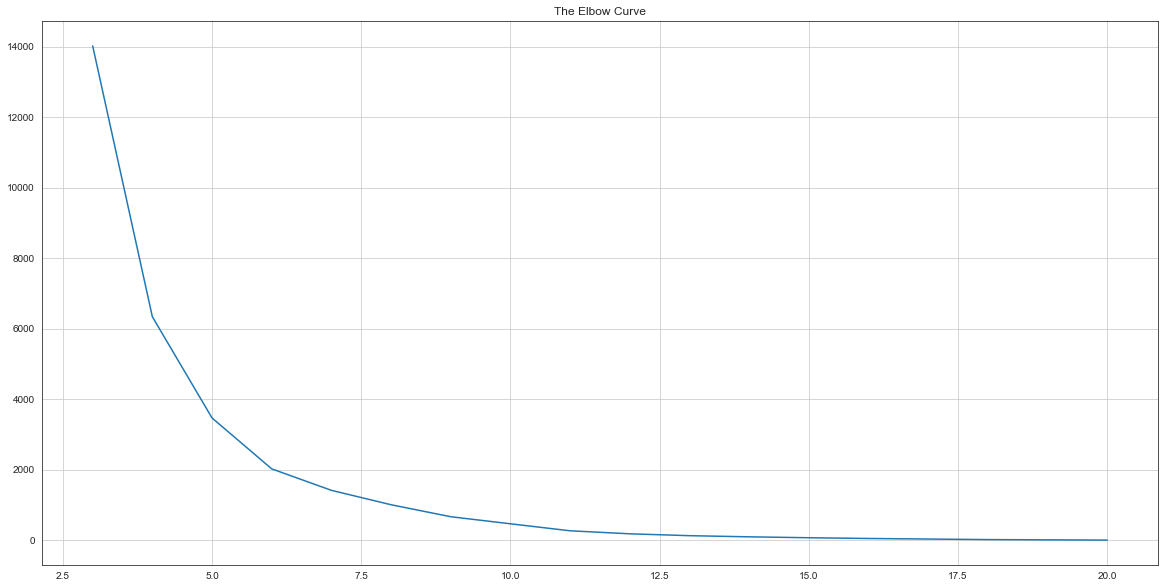

In [478]:
# Run the K-Means Algorithm with a K range from 3 to 21 to review the index of the clusters data points
distorsions = []
for k in range(3, 21):
    k_means = KMeans(n_clusters=k)
    k_means.fit(stockX)
    distorsions.append(k_means.inertia_)

# Plot the sum of squared distance (SSE) against the k value of K-Means
plt.figure(figsize=(20,10))
plt.plot(range(3, 21), distorsions)
plt.grid(True)
plt.title('The Elbow Curve')

As observed in the elbow curve above, the curve tends to flatten off at 5 and as such 5 will be adopted as the K value for the clustering of the stocks.

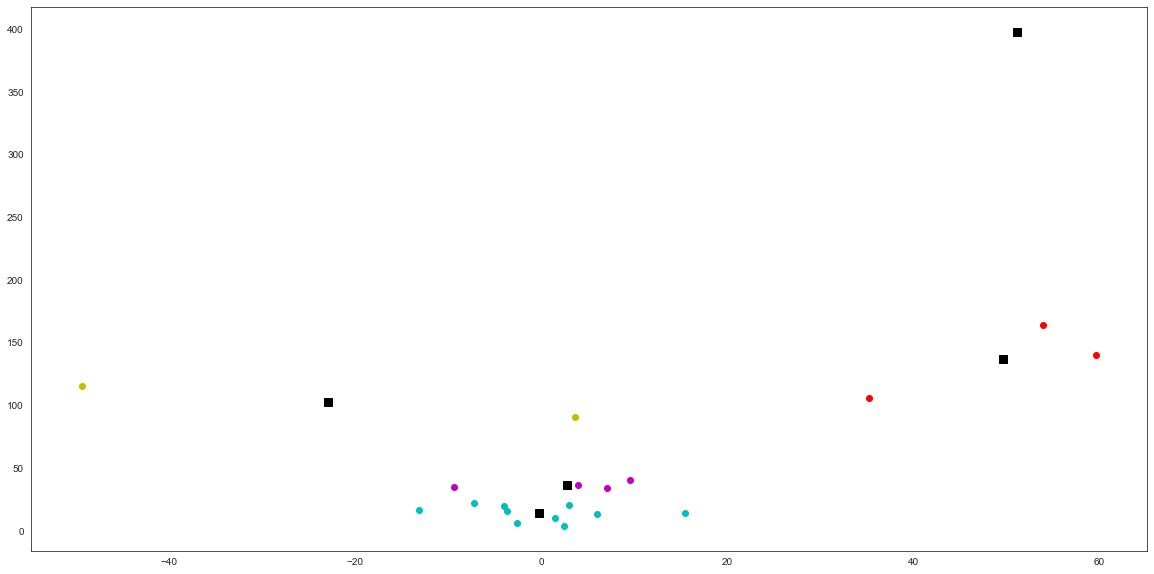

In [479]:
# Execute the K-Means Algorithm with the value of K=5 in line with the elbow curve discovery
centroids,_ = kmeans(stockX,5)

# Assign each of the stock to a cluster
idx,_ = vq(stockX,centroids)

# Plot the cluster indices of each of the stock using the logical indexing from numpy
plt.figure(figsize=(20,10))
plt.plot(stockX[idx==0,0],stockX[idx==0,1],'ob',
     stockX[idx==1,0],stockX[idx==1,1],'oy',
     stockX[idx==2,0],stockX[idx==2,1],'or',
     stockX[idx==3,0],stockX[idx==3,1],'oc',
     stockX[idx==4,0],stockX[idx==4,1],'om')
plt.plot(centroids[:,0],centroids[:,1],'sk',markersize=8)
plt.show()

In [480]:
# Print out the stocks with the clusters they belong based on the K-Means Algorithm
stockClusters = [(name,cluster) for name, cluster in zip(stockReturns.index,idx)]

for stockPoint in stockClusters:
    print(stockPoint)

('AIRA', 3)
('AJBNK', 3)
('AMAN', 2)
('AMANT', 3)
('ARMX', 3)
('ARTC', 3)
('DAMAC', 3)
('DEYR', 3)
('DFM', 3)
('DINV', 3)
('DISB', 2)
('DU', 3)
('DXBE', 4)
('EKTT', 4)
('EMAR', 1)
('ENBD', 4)
('SALAM', 4)
('SALAMA', 0)
('SHUA', 1)
('UPRO', 2)


<table width="100%">
  <tr>
    <th width="100"> <div >
      <div align="left">Clusters </div>
    </div></th>
    <th width="296"> <div >
      <div align="left">Listed Company </div>
    </div></th>
    <th width="120"> <div >
      <div align="left">Stock Symbol </div>
    </div></th>
    <th width="250"> <div >
      <div align="left">Sector </div>
    </div></th>
  </tr>
  <tr>
    <td align="right" bgcolor="#FFFFFF"><div >
      <div align="left">Cluster 1</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Islamic Arab Insurance Company</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">SALAMA</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Insurance</div>
    </div></td>
  </tr>
  <tr>
    <td rowspan="2" align="right" bgcolor="#FFFFCC"><div >
      <div align="left">Cluster 2</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Emaar Properties PJSC</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">EMAR</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Real Estate</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">SHUAA Capital PSC</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">SHUA</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Investment and Financial Services</div>
    </div></td>
  </tr>
  <tr>
    <td rowspan="3" align="right" bgcolor="#CCCCCC"><div >
      <div align="left">Cluster 3</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">Dubai Islamic Bank</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">DISB</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">Banking</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">Union Properties PJSC</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">UPRO</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">Real Estate</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">Dubai Islamic Insurance Co.</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">AMAN</div>
    </div></td>
    <td bgcolor="#CCCCCC"><div >
      <div align="left">Insurance</div>
    </div></td>
  </tr>
  <tr>
    <td rowspan="10" align="right" bgcolor="#FFFFFF"><div >
      <div align="left">Cluster 4</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Ajman Bank PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">AJBNK</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Banking</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Damac Properties Dubai Co PSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">DAMAC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Real Estate</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Deyaar Development PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">DEYR</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Real Estate</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Dubai Investments PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">DINV</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Investment and Financial Services</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Dubai Financial Market PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">DFM</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Investment and Financial Services</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">ARAMEX PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">ARMX</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Transportation</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Air Arabia PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">AIRA</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Transportation</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Emirate Integrated Telecom Co PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">DU</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Telecommunication</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Amanat Holdings PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">AMANT</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Healthcare and Education Investment</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Arabtec Holding PJSC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">ARTC</div>
    </div></td>
    <td bgcolor="#FFFFFF"><div >
      <div align="left">Construction</div>
    </div></td>
  </tr>
  <tr>
    <td rowspan="4" align="right" bgcolor="#FFFFCC"><div >
      <div align="left">Cluster 5</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Emirates NBD PJSC</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">ENBD</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Banking</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Al Salam Bank</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">SALAM</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Banking</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Ekttitab Holding Co. KSCC</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">EKTT</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Investment and Financial Services</div>
    </div></td>
  </tr>
  <tr>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">DXB Entertainments P.J.S.C.</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">DXBE</div>
    </div></td>
    <td bgcolor="#FFFFCC"><div >
      <div align="left">Consumer Staples and Discretionary</div>
    </div></td>
  </tr>
</table>

Despite optimising the K-Means Algorithm with the elbow curve discovery of the optimum K value that minimises the sum of squared distance, the majority (50%) of the stocks still remain in the same group which clearly shows that they are in tune with the stock market movement and perhaps with the economy. The clustering of the stocks also shows a pattern that the shares of companies in the same industry have a similar stock movement pattern in terms of the returns and volatility. However, the rates differ slightly from stock to stock. It is observed that about (50% - 100%) of the companies in the same industry fall in the same classification basket. Invariably, the K-Means Algorithm validates the H1 and H2 hypotheses.

Therefore, it can be concluded that:<br/>
H1: The stocks movements in profoundly impacted by the change of the entire market. **True**<br/>
H2: The stocks in the same industry follow a similar stock movement and direction. **True**<br/>

## Predictive Models
The objective of the predictive model is to provide the investor with an insight into the future stock close price. The DAMAC stock is considered in this case, and several features have been created during the data processing phase to predict the future stock close price. The linear regression will be used as the baseline for the predictive analysis. In an attempt to tune the parameters, the L1 and L2 penalty will be applied. Furthermore, the LSTM which has been proven to be effective in stock prediction will also be deployed to predict the DAMAC stock close price with its parameters tuned for better performance.

In [661]:
trainingSet = stockDAMAC[:1000]
validationSet = stockDAMAC[1000:]

stockDAMACX_train = trainingSet.drop('Close', axis=1)
stockDAMACY_train = pd.DataFrame(trainingSet['Close'])
stockDAMACX_test = validationSet.drop('Close', axis=1)
stockDAMACY_test = pd.DataFrame(validationSet['Close'])

In [662]:
# Define the 10 fold validation set for the K-fold validation
kf = KFold(n_splits = 10, shuffle=True, random_state=0)
kf.get_n_splits(stockDAMACX_train)

10

# Linear Regression

In [602]:
# Define the numpy scores' arrays to hold the scores while training on the training dataset 
train_scores = np.array([])
test_scores = np.array([])
mse_scores = np.array([])

# Instantiate the Linear Regression Model
lr = LinearRegression()

# For each of the 10-fold validation, fit the model on the 90% train and test with the 10% validation set.
for train_index, test_index in kf.split(stockDAMACX_train):
    x_train, x_test = stockDAMACX_train.loc[train_index], stockDAMACX_train.loc[test_index]
    y_train, y_test = stockDAMACY_train.loc[train_index], stockDAMACY_train.loc[test_index]
    
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    train_score = lr.score(x_train, y_train)
    test_score = lr.score(x_test, y_test)
    mse_score = mean_squared_error(y_pred, y_test)

    # Append the score from each iteration of the K-fold in the scores' arrays
    train_scores = np.append(train_scores, train_score)
    test_scores = np.append(test_scores, test_score)
    mse_scores = np.append(mse_scores, mse_score)

# Print the R Square on train and validation sets as well as the Mean Square Errors (MSE) on the validation sets.
print("R2 on Train Dataset:",train_scores[np.argmax(test_scores)])
print("R2 on Validation Dataset:",test_scores[np.argmax(test_scores)])
print("Average Mean Square Errors:",mse_scores.mean())
print("10-Fold Mean Square Errors:",mse_scores)

R2 on Train Dataset: 0.5114318752170757
R2 on Validation Dataset: 0.575184604311724
Average Mean Square Errors: 0.46530318690172584
10-Fold Mean Square Errors: [0.44290837 0.48053945 0.47829386 0.32204682 0.53128714 0.41350133
 0.56654697 0.47077372 0.44508309 0.50205112]


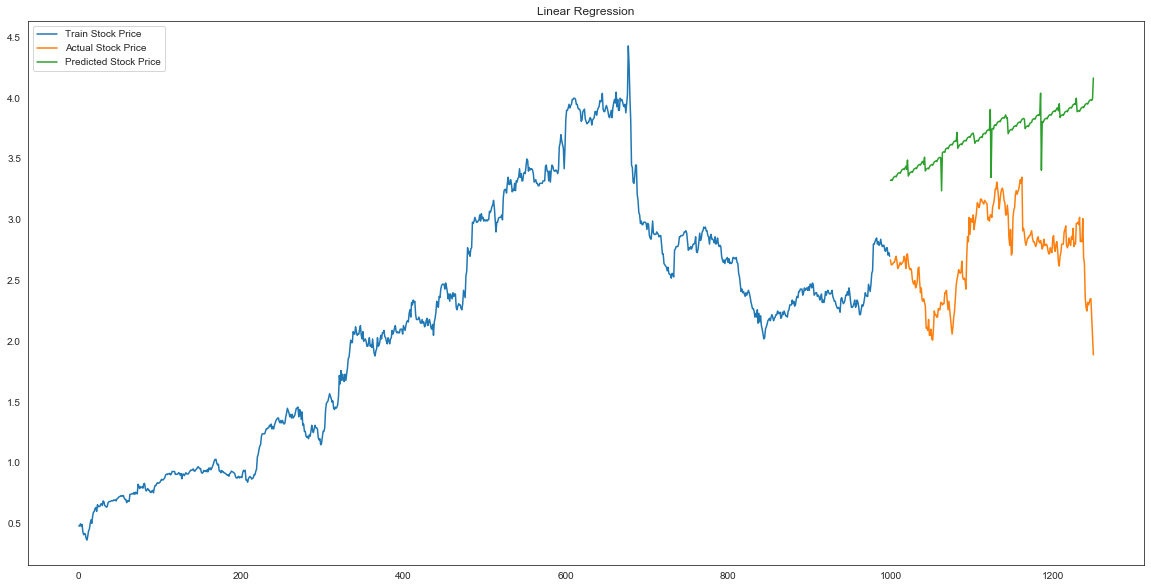

In [603]:
# Run a prediction for the DAMAC Close Price with the test dataset features and append the predicted values into the PredClose feature on the stockDAMACY_test Dataframe
preds = lr.predict(stockDAMACX_test)
stockDAMACY_test['PredClose'] = preds

# Plot the Train Close Stock Price, Test Close Stock Price and Predicted Close Stock Price to visualise the performance of the model.
plt.figure(figsize=(20,10))
plt.plot(stockDAMACY_train['Close'], label = "Train Stock Price")
plt.plot(stockDAMACY_test['Close'], label = "Actual Stock Price")
plt.plot(stockDAMACY_test['PredClose'], label = "Predicted Stock Price")
plt.title("Linear Regression")
plt.legend(loc='upper left')
plt.show()

In [604]:
# Print the Coefficients of the features of the Linear Regression 
print(lr.intercept_,lr.coef_)

[1225.74562952] [[-6.06236409e-01 -4.15755955e-02 -4.28057327e-03 -9.94102651e-03
  -2.93254230e-02  1.25420512e-01  1.11022302e-16  9.45637163e-02
   6.57680168e-02  1.86939105e-01 -5.19317549e-01]]


The Linear Regression coefficients show a positive correlation with the endMonth, startYear, endYear, isSummer and startQuarter independent variables in respect to the stock close price. While the Year, Month, Day, MarketOC, startMonth and endQuarter features are negatively correlated to the dependent variable.<br/>
The endMonth, startQuarter, endQuarter and Year features have high coefficients which show that these independent variables are highly relevant to the prediction close stock price. The isSummer and MarketOC are also assigned significant coefficients which not only confirm the hypotheses that the Market opening and closing days of the week as well as the summer end period have an impact on the close stock price but seem minimal, as most investors are aware of the trend and as such diluted the effect. The year-end period also contributes to the stock price as there appears to be a pattern as the year advances.

In [606]:
# Print the Root Mean Squared Error (RMSE) of the Linear Regression 
print("Root Mean Squared Error (RMSE):",np.sqrt(np.mean(np.power((stockDAMACY_test['Close']-stockDAMACY_test['PredClose']),2))))

Root Mean Squared Error (RMSE): 1.0188890426421644


The Root Mean Squared Error (RMSE) of the Linear Regression on the test dataset is relatively high, which indicates that the model is unable to learn the inherent pattern with the independent features. In the view to tune the model and reduce the RMSE for improved performance, the Lasso (L1) and Ridge (L2) regularisation methods will be adopted.

# Long Short Term Memory

In [607]:
#Create the trainingSet and validationSet for LSTM
dataset = stockDAMACClose.values
trainingSet = dataset[:1000]
validationSet = dataset[1000:]

In [611]:
# Use the MinMaxScaler to scale the data within the range 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Convert the training dataset into x_trainingSet and y_trainingSet array
x_trainingSet, y_trainingSet = [], []
for i in range(60,len(trainingSet)):
    x_trainingSet.append(scaled_data[i-60:i,0])
    y_trainingSet.append(scaled_data[i,0])
x_trainingSet, y_trainingSet = np.array(x_trainingSet), np.array(y_trainingSet)

x_trainingSet = np.reshape(x_trainingSet, (x_trainingSet.shape[0],x_trainingSet.shape[1],1))

# Instantiate and fit the LSTM Network
lstmodel = Sequential()
lstmodel.add(LSTM(units=50, return_sequences=True, input_shape=(x_trainingSet.shape[1],1)))
lstmodel.add(Dropout(0.5))
lstmodel.add(LSTM(units=50))
lstmodel.add(Dropout(0.5))
lstmodel.add(Dense(1))

lstmodel.compile(loss='mean_squared_error', optimizer='adam')
lstmodel.fit(x_trainingSet, y_trainingSet, epochs=1, batch_size=1, verbose=2)

# Predict 251 days close stock price, using the past 60 days from the trainingSet data
inputs = stockDAMACClose[len(stockDAMACClose) - len(validationSet) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_validationSet = []
for i in range(60,inputs.shape[0]):
    X_validationSet.append(inputs[i-60:i,0])
X_validationSet = np.array(X_validationSet)

X_validationSet = np.reshape(X_validationSet, (X_validationSet.shape[0],X_validationSet.shape[1],1))
preds = lstmodel.predict(X_validationSet)
preds = scaler.inverse_transform(preds)

Epoch 1/1
 - 65s - loss: 0.0030


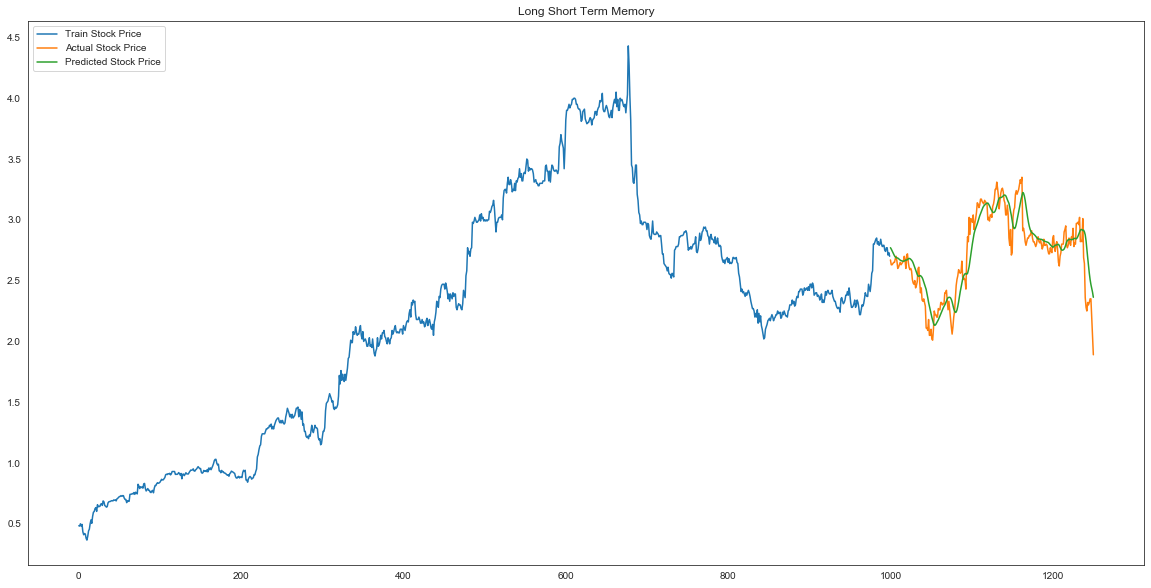

In [612]:
stockDAMACY_test['PredClose'] = preds
plt.figure(figsize=(20,10))
plt.plot(stockDAMACY_train['Close'], label = "Train Stock Price")
plt.plot(stockDAMACY_test['Close'], label = "Actual Stock Price")
plt.plot(stockDAMACY_test['PredClose'], label = "Predicted Stock Price")
plt.title("Long Short Term Memory")
plt.legend(loc='upper left')
plt.show()

In [613]:
# Print the Root Mean Squared Error (RMSE) of the Long Short Term Memory 
print("Root Mean Squared Error (RMSE):",np.sqrt(np.mean(np.power((stockDAMACY_test['Close']-stockDAMACY_test['PredClose']),2))))

Root Mean Squared Error (RMSE): 0.15465569016833583


The Long Short Term Memory recurrent neural network produces better performance in predicting DAMAC stock close prices with a significant lower RMSE score of 0.1547 when compared to Linear Regression. The Long Short Term Memory uses walk-forward model validation with the last 60 days of the close stock price to predict the following step. The epoch is set at 1, batch_size at 1, with a horizontal array of 50 LSTM units. The parameters of the algorithms will be tuned to further improve the performance of the models.

## Model Tuning: Predictive Model

The parameters of the predictive models aimed at predicting DAMAC stock close price will be tuned for improved performance and accuracy. The objective is to reduce the Root Mean Squared Error and the benchmarks as it stands now are as follows:<br/>
<table width="100%">
  <tr>
    <td>&nbsp;</td>
    <td>Linear Regression (LR)</td>
    <td>Long Short Term Memory (LSTM)</td>
  </tr>
  <tr>
    <td>Root Mean Squared Error (RMSE)</td>
    <td>1.0189</td>
    <td>0.1547</td>
  </tr>
</table>

# Lasso Regression

In [663]:
# Use the GridSearchCV to derive the best alpha parameter for Lasso
lasso = Lasso()
param = {'alpha':[0.0001,0.001,0.01,1,5,10,20]}
ls = GridSearchCV(lasso, param, scoring = 'neg_mean_squared_error', cv = 10)
ls.fit (stockDAMACX_train,stockDAMACY_train)
print(ls.best_params_)
print(ls.best_score_)

{'alpha': 0.01}
-0.7540250553779685


In [664]:
# Define the numpy scores' arrays to hold the scores while training on the training dataset 
train_scores = np.array([])
test_scores = np.array([])
mse_scores = np.array([])

# Instantiate the Lasso Regression Model with the best alpha param
ls = Lasso(alpha = 0.01)

# For each of the 10-fold validation, fit the model on the 90% train and test with the 10% validation set.
for train_index, test_index in kf.split(stockDAMACX_train):
    x_train, x_test = stockDAMACX_train.loc[train_index], stockDAMACX_train.loc[test_index]
    y_train, y_test = stockDAMACY_train.loc[train_index], stockDAMACY_train.loc[test_index]

    ls.fit(x_train, y_train)
    train_score = ls.score(x_train, y_train)
    test_score = ls.score(x_test, y_test)
    y_pred = ls.predict(x_test)
    mse_score = mean_squared_error(y_pred, y_test)

    # Append the score from each iteration of the K-fold in the scores' arrays    
    train_scores = np.append(train_scores, train_score)
    test_scores = np.append(test_scores, test_score)
    mse_scores = np.append(mse_scores, mse_score)

# Print the R Square on train and validation sets as well as the Mean Square Errors (MSE) on the validation sets.
print("R2 on Train Dataset:", train_scores[np.argmax(test_scores)])
print("R2 on Validation Dataset:",test_scores[np.argmax(test_scores)])
print("Average Mean Square Errors:",mse_scores.mean())
print("10-Fold Mean Square Errors:",mse_scores)

R2 on Train Dataset: 0.5100365365653746
R2 on Validation Dataset: 0.5624290687388966
Average Mean Square Errors: 0.463258599111558
10-Fold Mean Square Errors: [0.44290295 0.47486746 0.47555178 0.33171662 0.5298324  0.41773269
 0.55639635 0.45589252 0.44409392 0.5035993 ]


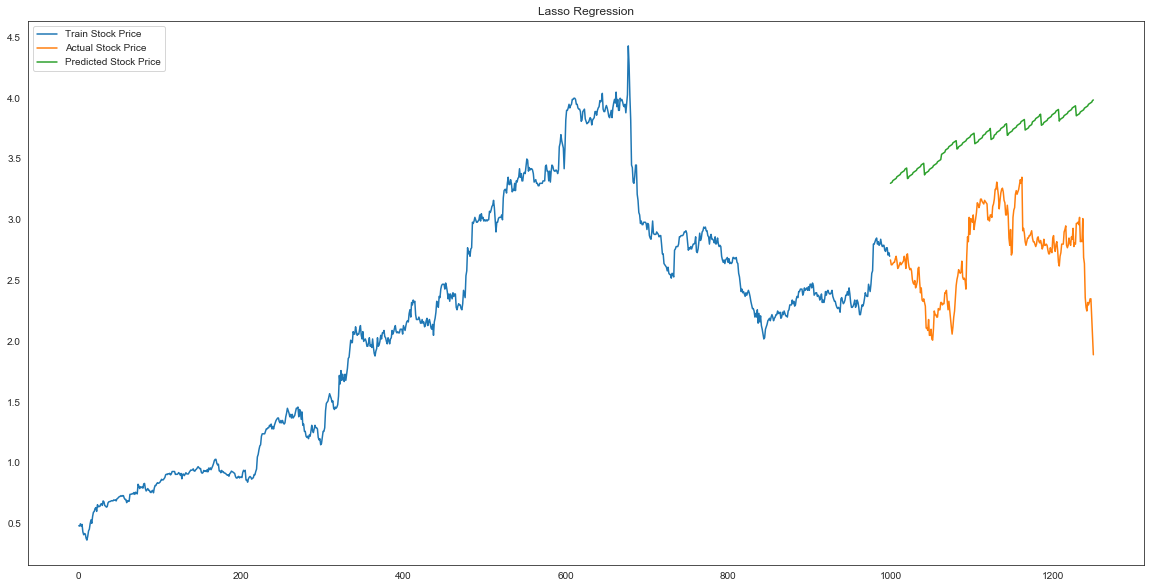

In [665]:
# Run a prediction for the DAMAC Close Price with the test dataset features and append the predicted values into the PredClose feature on the stockDAMACY_test Dataframe
preds = ls.predict(stockDAMACX_test)
stockDAMACY_test['PredClose'] = preds

# Plot the Train Close Stock Price, Test Close Stock Price and Predicted Close Stock Price to visualise the performance of the model.
plt.figure(figsize=(20,10))
plt.plot(stockDAMACY_train['Close'], label = "Train Stock Price")
plt.plot(stockDAMACY_test['Close'], label = "Actual Stock Price")
plt.plot(stockDAMACY_test['PredClose'], label = "Predicted Stock Price")
plt.title("Lasso Regression")
plt.legend(loc='upper left')
plt.show()

In [666]:
# Lasso Regression Coefficient
print(ls.intercept_,ls.coef_)

[1210.61423176] [-0.59874342 -0.03903704 -0.00449612 -0.          0.         -0.
  0.         -0.          0.          0.         -0.        ]


In [667]:
# Print the Root Mean Squared Error (RMSE) of the Lasso Regression
print("Root Mean Squared Error (RMSE):",np.sqrt(np.mean(np.power((stockDAMACY_test['Close']-stockDAMACY_test['PredClose']),2))))

Root Mean Squared Error (RMSE): 1.000010432757428


The L1 regularisation in the attempt to penalise the parameters in the model to an absolute value of the coefficients' magnitude, set most of the coefficients to zero except for the Year, Month and Day features. The has made the model to have high variant and low bias as it seems not to sufficiently learn the pattern in the training data. The RMSE has also not significantly improved when compared to the RMSE value for Linear Regression. The Ridge regularisation will be applied to see if it will produce a better performance and accuracy.

# Ridge Regression

In [614]:
# Use the GridSearchCV to derive the best alpha parameter for Ridge
ridge = Ridge()
param = {'alpha':[0.0001,0.001,0.01,1,5,10,20]}
lm = GridSearchCV(ridge, param, scoring = 'neg_mean_squared_error', cv = 10)
lm.fit (stockDAMACX_train,stockDAMACY_train)
print(lm.best_params_)
print(lm.best_score_)

{'alpha': 20}
-0.7595135802578993


In [615]:
# Define the numpy scores' arrays to hold the scores while training on the training dataset 
train_scores = np.array([])
test_scores = np.array([])
mse_scores = np.array([])

# Instantiate the Ridge Regression Model with the best alpha param
lm = Ridge(alpha = 20)

# For each of the 10-fold validation, fit the model on the 90% train and test with the 10% validation set.
for train_index, test_index in kf.split(stockDAMACX_train):
    x_train, x_test = stockDAMACX_train.loc[train_index], stockDAMACX_train.loc[test_index]
    y_train, y_test = stockDAMACY_train.loc[train_index], stockDAMACY_train.loc[test_index]
   

    lm.fit(x_train, y_train)
    train_score = lm.score(x_train, y_train)
    test_score = lm.score(x_test, y_test)
    y_pred = lm.predict(x_test)
    mse_score = mean_squared_error(y_pred, y_test)

    # Append the score from each iteration of the K-fold in the scores' arrays    
    train_scores = np.append(train_scores, train_score)
    test_scores = np.append(test_scores, test_score)
    mse_scores = np.append(mse_scores, mse_score)
    
# Print the R Square on train and validation sets as well as the Mean Square Errors (MSE) on the validation sets.    
print("R2 on Train Dataset:", train_scores[np.argmax(test_scores)])
print("R2 on Validation Dataset:",test_scores[np.argmax(test_scores)])
print("Average Mean Square Errors:",mse_scores.mean())
print("10-Fold Mean Square Errors:",mse_scores)

R2 on Train Dataset: 0.510718767573786
R2 on Validation Dataset: 0.5663296501633568
Average Mean Square Errors: 0.4642159776079323
10-Fold Mean Square Errors: [0.44382565 0.47501739 0.47882675 0.32875964 0.5300641  0.41667005
 0.56204034 0.45983587 0.4458161  0.50130388]


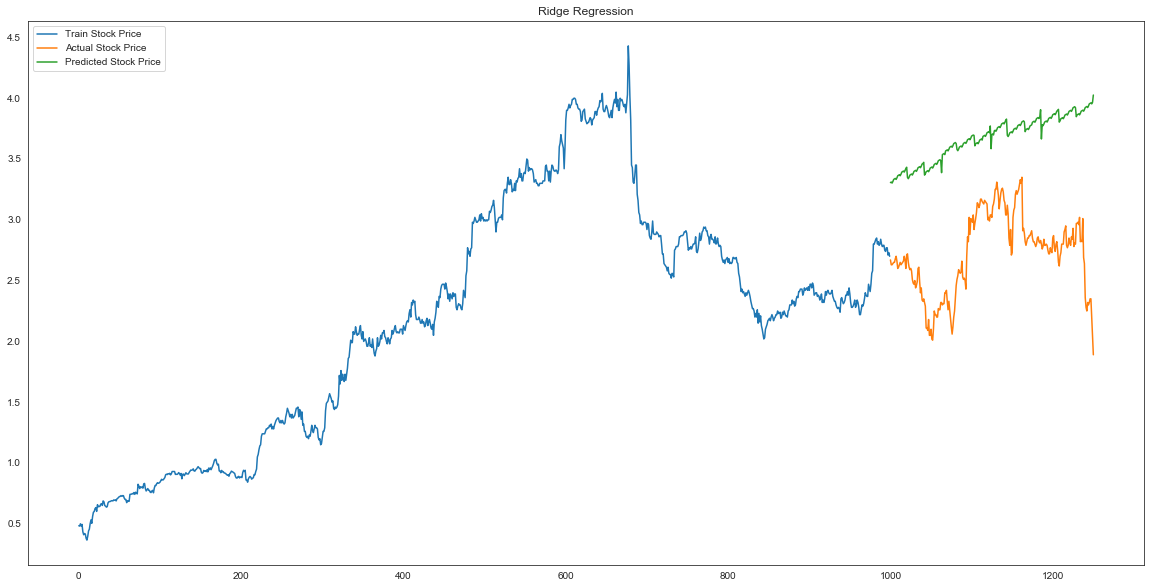

In [616]:
# Run a prediction for the DAMAC Close Price with the test dataset features and append the predicted values into the PredClose feature on the stockDAMACY_test Dataframe
preds = lm.predict(stockDAMACX_test)
stockDAMACY_test['PredClose'] = preds

# Plot the Train Close Stock Price, Test Close Stock Price and Predicted Close Stock Price to visualise the performance of the model.
plt.figure(figsize=(20,10))
plt.plot(stockDAMACY_train['Close'], label = "Train Stock Price")
plt.plot(stockDAMACY_test['Close'], label = "Actual Stock Price")
plt.plot(stockDAMACY_test['PredClose'], label = "Predicted Stock Price")
plt.title("Ridge Regression")
plt.legend(loc='upper left')
plt.show()

In [617]:
# Ridge Regression Coefficient
print(lm.intercept_,lm.coef_)

[1206.85730194] [[-0.59687774 -0.0402642  -0.00430858 -0.01279834  0.00549695  0.00233289
   0.         -0.01848083  0.04064284  0.03720135 -0.11538761]]


In [619]:
# Print the Root Mean Squared Error (RMSE) of the Ridge Regression
print("Root Mean Squared Error (RMSE):",np.sqrt(np.mean(np.power((stockDAMACY_test['Close']-stockDAMACY_test['PredClose']),2))))

Root Mean Squared Error (RMSE): 0.9948918341575235


Indeed, the L2 slightly performs better than the L1 in terms of learning the patterns in the training data with a higher R-Square value on train data and subsequently, a higher slightly higher RMSE on test data. Meanwhile, it is evident in the charts above that the regression algorithms have not performed well with the time series prediction of the DAMAC future stock close price.

<table width="100%" >
  <tr>
    <td><div align="center"></div></td>
    <td><div align="center">Linear Regression</div></td>
    <td><div align="center">Lasso Regression</div></td>
    <td><div align="center">Ridge Regression</div></td>
  </tr>
  <tr>
    <td><div align="center">Root Mean Squared Error (RMSE)</div></td>
    <td><div align="center">1.0188890426421644</div></td>
    <td><div align="center">1.000010432757428</div></td>
    <td><div align="center">0.9948918341575235</div></td>
  </tr>
</table>

The Lasso and Ridge regression did not show significant improvement in terms of performance and accuracy over the Linear Regression. The regularisation operators may have performed better in the case of a high set of independent features which is not present in this analysis. Though the regression algorithms with the penalty parameter produced an R-Square of 51% on train dataset and 56 - 57% on validation dataset of the k-fold, the RMSE remain relatively low with the ranges between 1.01889 - 0.99489 which is higher than the RMSE of 0.15466 obtained from the original LSTM network. It is instructive at this junction to further tune the parameters of the LSTM for improved accuracy as it tends to yield better results.

Further work on the use of Linear regression to predict the future stock close price will adopt additional independent features such as sentiment analysis from the news. Although the coefficients assigned to the MarketOC and isSummer features in the Linear Regression Coefficient and the regularised Ridge Regression Coefficient support the significance of the market opening day and closing day of the week and impact of the after summer period on the prediction of the future stock close price and as such validates the hypotheses, H3 and H4 propositions:<br/>
H3: The return on stocks is higher on the first and last days of the market trading week. **True**<br/>
H4: The return on stocks is lower in the month after summer. **True**<br/>

# Long Short Term Memory

In [562]:
# Use the MinMaxScaler to scale the data within the range 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Define the epochs parameters
param_epochs_list = [1, 10, 50]

# Define the batch_size parameters
param_batch_list = [1, 8, 16]

# Define the number of days features parameters
param_features_list = [30, 45, 60]

# Define the lstm_units parameters
param_units_list = [10, 50, 64]

# Define the dropout_prob parameters
param_dropout_list = [0.5, 0.7, 1]

for param1 in param_epochs_list:
    for param2 in param_batch_list:
        for param3 in param_features_list:
            for param4 in param_units_list:
                for param5 in param_dropout_list:

                    # Convert the training dataset into x_trainingSet and y_trainingSet array
                    x_trainingSet, y_trainingSet = [], []
                    for i in range(param3,len(trainingSet)):
                        x_trainingSet.append(scaled_data[i-param3:i,0])
                        y_trainingSet.append(scaled_data[i,0])
                    x_trainingSet, y_trainingSet = np.array(x_trainingSet), np.array(y_trainingSet)

                    x_trainingSet = np.reshape(x_trainingSet, (x_trainingSet.shape[0],x_trainingSet.shape[1],1))

                    # Instantiate and fit the LSTM Network
                    lstmodel = Sequential()
                    lstmodel.add(LSTM(units=param4, return_sequences=True, input_shape=(x_trainingSet.shape[1],1)))
                    lstmodel.add(Dropout(param5))
                    lstmodel.add(LSTM(units=param4))
                    lstmodel.add(Dropout(param5))
                    lstmodel.add(Dense(1))

                    lstmodel.compile(loss='mean_squared_error', optimizer='adam')
                    lstmodel.fit(x_trainingSet, y_trainingSet, epochs=param1, batch_size=param2, verbose=2)

                    #predicting 251 values, using past no of days in the feature parameter from the trainingSet data
                    inputs = stockDAMACClose[len(stockDAMACClose) - len(validationSet) - param3:].values
                    inputs = inputs.reshape(-1,1)
                    inputs  = scaler.transform(inputs)

                    X_validationSet = []
                    for i in range(param3,inputs.shape[0]):
                        X_validationSet.append(inputs[i-param3:i,0])
                    X_validationSet = np.array(X_validationSet)

                    X_validationSet = np.reshape(X_validationSet, (X_validationSet.shape[0],X_validationSet.shape[1],1))
                    preds = lstmodel.predict(X_validationSet)
                    preds = scaler.inverse_transform(preds)

                    stockDAMACY_test['PredClose'] = preds
                    print(f"Root Mean Squared Error (RMSE) for epochs - {param1} | batch_size - {param2} | features - {param3} | lstm_units - {param4} | dropout_list - {param5}:",np.sqrt(np.mean(np.power((stockDAMACY_test['Close']-stockDAMACY_test['PredClose']),2))))

Epoch 1/1
 - 27s - loss: 0.0332
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 1 | features - 30 | lstm_units - 10 | dropout_list - 0.5: 0.199894181217564
Epoch 1/1
 - 27s - loss: 0.0530
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 1 | features - 30 | lstm_units - 10 | dropout_list - 0.7: 0.48248088668327344
Epoch 1/1
 - 27s - loss: 0.0042
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 1 | features - 30 | lstm_units - 10 | dropout_list - 1: 0.19247421747760526
Epoch 1/1
 - 25s - loss: 0.0131
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 1 | features - 30 | lstm_units - 50 | dropout_list - 0.5: 0.16408454165149972
Epoch 1/1
 - 26s - loss: 0.0235
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 1 | features - 30 | lstm_units - 50 | dropout_list - 0.7: 0.21213551697815378
Epoch 1/1
 - 25s - loss: 0.0037
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 1 | features - 30 | lstm_units - 50 | dropout_list - 1: 

Epoch 1/1
 - 8s - loss: 0.0120
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 8 | features - 45 | lstm_units - 64 | dropout_list - 1: 0.18045652874853602
Epoch 1/1
 - 6s - loss: 0.0687
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 8 | features - 60 | lstm_units - 10 | dropout_list - 0.5: 0.24623520951776995
Epoch 1/1
 - 6s - loss: 0.0922
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 8 | features - 60 | lstm_units - 10 | dropout_list - 0.7: 0.7013221973510073
Epoch 1/1
 - 6s - loss: 0.0411
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 8 | features - 60 | lstm_units - 10 | dropout_list - 1: 0.22654480493145338
Epoch 1/1
 - 9s - loss: 0.0258
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 8 | features - 60 | lstm_units - 50 | dropout_list - 0.5: 0.21866056538955267
Epoch 1/1
 - 8s - loss: 0.0300
Root Mean Squared Error (RMSE) for epochs - 1 | batch_size - 8 | features - 60 | lstm_units - 50 | dropout_list - 0.7: 0.370

 - 28s - loss: 0.0251
Epoch 2/10
 - 26s - loss: 0.0104
Epoch 3/10
 - 27s - loss: 0.0077
Epoch 4/10
 - 27s - loss: 0.0060
Epoch 5/10
 - 27s - loss: 0.0063
Epoch 6/10
 - 27s - loss: 0.0063
Epoch 7/10
 - 27s - loss: 0.0063
Epoch 8/10
 - 27s - loss: 0.0057
Epoch 9/10
 - 27s - loss: 0.0065
Epoch 10/10
 - 27s - loss: 0.0052
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 1 | features - 30 | lstm_units - 50 | dropout_list - 0.7: 0.20312615902223383
Epoch 1/10
 - 28s - loss: 0.0040
Epoch 2/10
 - 30s - loss: 9.9908e-04
Epoch 3/10
 - 31s - loss: 7.0725e-04
Epoch 4/10
 - 31s - loss: 7.6749e-04
Epoch 5/10
 - 29s - loss: 5.1213e-04
Epoch 6/10
 - 25s - loss: 5.3105e-04
Epoch 7/10
 - 24s - loss: 3.7168e-04
Epoch 8/10
 - 24s - loss: 3.4771e-04
Epoch 9/10
 - 24s - loss: 2.9658e-04
Epoch 10/10
 - 24s - loss: 2.7284e-04
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 1 | features - 30 | lstm_units - 50 | dropout_list - 1: 0.0807556613978086
Epoch 1/10
 - 25s - loss: 0.0116
Epo

Epoch 2/10
 - 54s - loss: 0.0065
Epoch 3/10
 - 52s - loss: 0.0048
Epoch 4/10
 - 44s - loss: 0.0042
Epoch 5/10
 - 44s - loss: 0.0036
Epoch 6/10
 - 44s - loss: 0.0033
Epoch 7/10
 - 45s - loss: 0.0028
Epoch 8/10
 - 44s - loss: 0.0031
Epoch 9/10
 - 46s - loss: 0.0031
Epoch 10/10
 - 44s - loss: 0.0028
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 1 | features - 60 | lstm_units - 50 | dropout_list - 0.5: 0.1331626719270735
Epoch 1/10
 - 45s - loss: 0.0262
Epoch 2/10
 - 44s - loss: 0.0109
Epoch 3/10
 - 45s - loss: 0.0078
Epoch 4/10
 - 46s - loss: 0.0062
Epoch 5/10
 - 45s - loss: 0.0065
Epoch 6/10
 - 47s - loss: 0.0059
Epoch 7/10
 - 54s - loss: 0.0055
Epoch 8/10
 - 52s - loss: 0.0054
Epoch 9/10
 - 52s - loss: 0.0053
Epoch 10/10
 - 52s - loss: 0.0056
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 1 | features - 60 | lstm_units - 50 | dropout_list - 0.7: 0.20574797744670129
Epoch 1/10
 - 54s - loss: 0.0035
Epoch 2/10
 - 55s - loss: 0.0011
Epoch 3/10
 - 51s - loss: 

Epoch 7/10
 - 5s - loss: 7.2911e-04
Epoch 8/10
 - 5s - loss: 6.2937e-04
Epoch 9/10
 - 5s - loss: 6.7381e-04
Epoch 10/10
 - 5s - loss: 5.5314e-04
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 8 | features - 45 | lstm_units - 10 | dropout_list - 1: 0.14161776261758735
Epoch 1/10
 - 8s - loss: 0.0259
Epoch 2/10
 - 7s - loss: 0.0095
Epoch 3/10
 - 7s - loss: 0.0077
Epoch 4/10
 - 7s - loss: 0.0071
Epoch 5/10
 - 7s - loss: 0.0068
Epoch 6/10
 - 7s - loss: 0.0065
Epoch 7/10
 - 7s - loss: 0.0054
Epoch 8/10
 - 7s - loss: 0.0052
Epoch 9/10
 - 7s - loss: 0.0048
Epoch 10/10
 - 7s - loss: 0.0043
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 8 | features - 45 | lstm_units - 50 | dropout_list - 0.5: 0.15616688767890902
Epoch 1/10
 - 8s - loss: 0.0333
Epoch 2/10
 - 7s - loss: 0.0163
Epoch 3/10
 - 7s - loss: 0.0137
Epoch 4/10
 - 7s - loss: 0.0118
Epoch 5/10
 - 7s - loss: 0.0118
Epoch 6/10
 - 7s - loss: 0.0100
Epoch 7/10
 - 7s - loss: 0.0079
Epoch 8/10
 - 7s - loss: 0.0080


Epoch 1/10
 - 2s - loss: 0.0423
Epoch 2/10
 - 1s - loss: 0.0019
Epoch 3/10
 - 2s - loss: 0.0012
Epoch 4/10
 - 2s - loss: 0.0011
Epoch 5/10
 - 2s - loss: 0.0011
Epoch 6/10
 - 1s - loss: 0.0010
Epoch 7/10
 - 2s - loss: 9.9060e-04
Epoch 8/10
 - 2s - loss: 9.4842e-04
Epoch 9/10
 - 2s - loss: 9.2770e-04
Epoch 10/10
 - 2s - loss: 9.0079e-04
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 16 | features - 30 | lstm_units - 10 | dropout_list - 1: 0.1695643885501806
Epoch 1/10
 - 3s - loss: 0.0316
Epoch 2/10
 - 2s - loss: 0.0092
Epoch 3/10
 - 2s - loss: 0.0088
Epoch 4/10
 - 2s - loss: 0.0083
Epoch 5/10
 - 2s - loss: 0.0075
Epoch 6/10
 - 2s - loss: 0.0066
Epoch 7/10
 - 2s - loss: 0.0066
Epoch 8/10
 - 2s - loss: 0.0060
Epoch 9/10
 - 2s - loss: 0.0065
Epoch 10/10
 - 2s - loss: 0.0050
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 16 | features - 30 | lstm_units - 50 | dropout_list - 0.5: 0.16337566066238607
Epoch 1/10
 - 3s - loss: 0.0327
Epoch 2/10
 - 3s - loss: 0.0184

Epoch 8/10
 - 4s - loss: 0.0286
Epoch 9/10
 - 4s - loss: 0.0233
Epoch 10/10
 - 3s - loss: 0.0238
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 16 | features - 60 | lstm_units - 10 | dropout_list - 0.7: 0.3613535073355317
Epoch 1/10
 - 4s - loss: 0.0356
Epoch 2/10
 - 3s - loss: 0.0020
Epoch 3/10
 - 3s - loss: 0.0014
Epoch 4/10
 - 3s - loss: 0.0013
Epoch 5/10
 - 3s - loss: 0.0013
Epoch 6/10
 - 3s - loss: 0.0012
Epoch 7/10
 - 3s - loss: 0.0011
Epoch 8/10
 - 4s - loss: 0.0011
Epoch 9/10
 - 3s - loss: 0.0011
Epoch 10/10
 - 3s - loss: 9.9814e-04
Root Mean Squared Error (RMSE) for epochs - 10 | batch_size - 16 | features - 60 | lstm_units - 10 | dropout_list - 1: 0.17517275263384055
Epoch 1/10
 - 5s - loss: 0.0307
Epoch 2/10
 - 4s - loss: 0.0102
Epoch 3/10
 - 4s - loss: 0.0099
Epoch 4/10
 - 4s - loss: 0.0088
Epoch 5/10
 - 4s - loss: 0.0071
Epoch 6/10
 - 5s - loss: 0.0068
Epoch 7/10
 - 4s - loss: 0.0075
Epoch 8/10
 - 4s - loss: 0.0060
Epoch 9/10
 - 4s - loss: 0.0067
Epoch 10/10

Epoch 28/50
 - 25s - loss: 2.1302e-04
Epoch 29/50
 - 25s - loss: 2.0750e-04
Epoch 30/50
 - 25s - loss: 2.0732e-04
Epoch 31/50
 - 25s - loss: 2.1776e-04
Epoch 32/50
 - 24s - loss: 2.2168e-04
Epoch 33/50
 - 25s - loss: 1.9185e-04
Epoch 34/50
 - 25s - loss: 2.1511e-04
Epoch 35/50
 - 24s - loss: 2.0184e-04
Epoch 36/50
 - 24s - loss: 2.3161e-04
Epoch 37/50
 - 24s - loss: 2.2226e-04
Epoch 38/50
 - 24s - loss: 1.8365e-04
Epoch 39/50
 - 25s - loss: 1.9694e-04
Epoch 40/50
 - 24s - loss: 2.1544e-04
Epoch 41/50
 - 29s - loss: 1.8836e-04
Epoch 42/50
 - 31s - loss: 1.9089e-04
Epoch 43/50
 - 32s - loss: 1.9098e-04
Epoch 44/50
 - 36s - loss: 2.1131e-04
Epoch 45/50
 - 37s - loss: 2.2401e-04
Epoch 46/50
 - 36s - loss: 1.9654e-04
Epoch 47/50
 - 36s - loss: 2.0033e-04
Epoch 48/50
 - 36s - loss: 1.9994e-04
Epoch 49/50
 - 29s - loss: 1.8823e-04
Epoch 50/50
 - 27s - loss: 1.7818e-04
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 1 | features - 30 | lstm_units - 10 | dropout_list - 1: 0.086852

 - 27s - loss: 0.0018
Epoch 46/50
 - 26s - loss: 0.0018
Epoch 47/50
 - 25s - loss: 0.0020
Epoch 48/50
 - 25s - loss: 0.0020
Epoch 49/50
 - 26s - loss: 0.0021
Epoch 50/50
 - 27s - loss: 0.0018
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 1 | features - 30 | lstm_units - 64 | dropout_list - 0.5: 0.09319457331621728
Epoch 1/50
 - 27s - loss: 0.0207
Epoch 2/50
 - 26s - loss: 0.0096
Epoch 3/50
 - 26s - loss: 0.0073
Epoch 4/50
 - 26s - loss: 0.0063
Epoch 5/50
 - 26s - loss: 0.0061
Epoch 6/50
 - 27s - loss: 0.0055
Epoch 7/50
 - 27s - loss: 0.0057
Epoch 8/50
 - 25s - loss: 0.0048
Epoch 9/50
 - 27s - loss: 0.0052
Epoch 10/50
 - 31s - loss: 0.0046
Epoch 11/50
 - 35s - loss: 0.0051
Epoch 12/50
 - 30s - loss: 0.0051
Epoch 13/50
 - 30s - loss: 0.0045
Epoch 14/50
 - 31s - loss: 0.0042
Epoch 15/50
 - 30s - loss: 0.0047
Epoch 16/50
 - 38s - loss: 0.0046
Epoch 17/50
 - 34s - loss: 0.0049
Epoch 18/50
 - 35s - loss: 0.0045
Epoch 19/50
 - 30s - loss: 0.0042
Epoch 20/50
 - 32s - loss: 0.00

Epoch 11/50
 - 34s - loss: 3.9531e-04
Epoch 12/50
 - 35s - loss: 3.4314e-04
Epoch 13/50
 - 36s - loss: 3.2679e-04
Epoch 14/50
 - 36s - loss: 2.9908e-04
Epoch 15/50
 - 46s - loss: 2.5990e-04
Epoch 16/50
 - 47s - loss: 2.2976e-04
Epoch 17/50
 - 46s - loss: 2.3077e-04
Epoch 18/50
 - 47s - loss: 2.4945e-04
Epoch 19/50
 - 47s - loss: 2.2475e-04
Epoch 20/50
 - 40s - loss: 2.1029e-04
Epoch 21/50
 - 35s - loss: 2.1544e-04
Epoch 22/50
 - 34s - loss: 2.0787e-04
Epoch 23/50
 - 35s - loss: 2.1996e-04
Epoch 24/50
 - 35s - loss: 2.2461e-04
Epoch 25/50
 - 35s - loss: 2.1948e-04
Epoch 26/50
 - 34s - loss: 2.1216e-04
Epoch 27/50
 - 35s - loss: 1.9105e-04
Epoch 28/50
 - 35s - loss: 2.3288e-04
Epoch 29/50
 - 35s - loss: 2.1007e-04
Epoch 30/50
 - 35s - loss: 2.1321e-04
Epoch 31/50
 - 34s - loss: 2.0824e-04
Epoch 32/50
 - 35s - loss: 1.9936e-04
Epoch 33/50
 - 34s - loss: 2.0347e-04
Epoch 34/50
 - 35s - loss: 2.0148e-04
Epoch 35/50
 - 34s - loss: 2.2479e-04
Epoch 36/50
 - 35s - loss: 2.1449e-04
Epoch 37/50


 - 42s - loss: 0.0021
Epoch 27/50
 - 42s - loss: 0.0020
Epoch 28/50
 - 42s - loss: 0.0023
Epoch 29/50
 - 43s - loss: 0.0020
Epoch 30/50
 - 40s - loss: 0.0022
Epoch 31/50
 - 38s - loss: 0.0020
Epoch 32/50
 - 38s - loss: 0.0019
Epoch 33/50
 - 40s - loss: 0.0024
Epoch 34/50
 - 40s - loss: 0.0019
Epoch 35/50
 - 38s - loss: 0.0018
Epoch 36/50
 - 39s - loss: 0.0019
Epoch 37/50
 - 42s - loss: 0.0022
Epoch 38/50
 - 42s - loss: 0.0019
Epoch 39/50
 - 39s - loss: 0.0021
Epoch 40/50
 - 39s - loss: 0.0017
Epoch 41/50
 - 39s - loss: 0.0019
Epoch 42/50
 - 36s - loss: 0.0018
Epoch 43/50
 - 42s - loss: 0.0020
Epoch 44/50
 - 43s - loss: 0.0020
Epoch 45/50
 - 43s - loss: 0.0021
Epoch 46/50
 - 43s - loss: 0.0018
Epoch 47/50
 - 42s - loss: 0.0018
Epoch 48/50
 - 42s - loss: 0.0019
Epoch 49/50
 - 41s - loss: 0.0018
Epoch 50/50
 - 47s - loss: 0.0019
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 1 | features - 45 | lstm_units - 64 | dropout_list - 0.5: 0.0926986131162652
Epoch 1/50
 - 44s - los

 - 60s - loss: 0.0117
Epoch 47/50
 - 59s - loss: 0.0126
Epoch 48/50
 - 58s - loss: 0.0124
Epoch 49/50
 - 59s - loss: 0.0126
Epoch 50/50
 - 46s - loss: 0.0116
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 1 | features - 60 | lstm_units - 10 | dropout_list - 0.7: 0.22843424303347012
Epoch 1/50
 - 45s - loss: 0.0021
Epoch 2/50
 - 46s - loss: 0.0011
Epoch 3/50
 - 46s - loss: 9.9528e-04
Epoch 4/50
 - 44s - loss: 7.9222e-04
Epoch 5/50
 - 46s - loss: 7.2368e-04
Epoch 6/50
 - 46s - loss: 6.3007e-04
Epoch 7/50
 - 45s - loss: 5.0231e-04
Epoch 8/50
 - 48s - loss: 4.6689e-04
Epoch 9/50
 - 47s - loss: 4.5946e-04
Epoch 10/50
 - 44s - loss: 4.4710e-04
Epoch 11/50
 - 46s - loss: 3.4653e-04
Epoch 12/50
 - 45s - loss: 3.3324e-04
Epoch 13/50
 - 54s - loss: 3.3803e-04
Epoch 14/50
 - 60s - loss: 2.5708e-04
Epoch 15/50
 - 57s - loss: 2.5128e-04
Epoch 16/50
 - 57s - loss: 2.3282e-04
Epoch 17/50
 - 58s - loss: 2.2417e-04
Epoch 18/50
 - 50s - loss: 2.4251e-04
Epoch 19/50
 - 45s - loss: 2.1744e-

Epoch 7/50
 - 50s - loss: 0.0027
Epoch 8/50
 - 50s - loss: 0.0027
Epoch 9/50
 - 55s - loss: 0.0028
Epoch 10/50
 - 56s - loss: 0.0026
Epoch 11/50
 - 56s - loss: 0.0024
Epoch 12/50
 - 57s - loss: 0.0027
Epoch 13/50
 - 57s - loss: 0.0024
Epoch 14/50
 - 56s - loss: 0.0024
Epoch 15/50
 - 57s - loss: 0.0024
Epoch 16/50
 - 51s - loss: 0.0023
Epoch 17/50
 - 50s - loss: 0.0024
Epoch 18/50
 - 50s - loss: 0.0027
Epoch 19/50
 - 48s - loss: 0.0023
Epoch 20/50
 - 49s - loss: 0.0022
Epoch 21/50
 - 50s - loss: 0.0021
Epoch 22/50
 - 50s - loss: 0.0024
Epoch 23/50
 - 50s - loss: 0.0019
Epoch 24/50
 - 50s - loss: 0.0020
Epoch 25/50
 - 47s - loss: 0.0022
Epoch 26/50
 - 53s - loss: 0.0020
Epoch 27/50
 - 56s - loss: 0.0022
Epoch 28/50
 - 55s - loss: 0.0021
Epoch 29/50
 - 55s - loss: 0.0020
Epoch 30/50
 - 56s - loss: 0.0019
Epoch 31/50
 - 55s - loss: 0.0019
Epoch 32/50
 - 55s - loss: 0.0019
Epoch 33/50
 - 50s - loss: 0.0020
Epoch 34/50
 - 47s - loss: 0.0021
Epoch 35/50
 - 48s - loss: 0.0016
Epoch 36/50
 - 48

 - 4s - loss: 0.0132
Epoch 30/50
 - 3s - loss: 0.0124
Epoch 31/50
 - 4s - loss: 0.0122
Epoch 32/50
 - 3s - loss: 0.0126
Epoch 33/50
 - 4s - loss: 0.0119
Epoch 34/50
 - 4s - loss: 0.0123
Epoch 35/50
 - 3s - loss: 0.0116
Epoch 36/50
 - 3s - loss: 0.0122
Epoch 37/50
 - 3s - loss: 0.0126
Epoch 38/50
 - 4s - loss: 0.0122
Epoch 39/50
 - 4s - loss: 0.0124
Epoch 40/50
 - 4s - loss: 0.0122
Epoch 41/50
 - 3s - loss: 0.0125
Epoch 42/50
 - 3s - loss: 0.0122
Epoch 43/50
 - 3s - loss: 0.0125
Epoch 44/50
 - 3s - loss: 0.0119
Epoch 45/50
 - 3s - loss: 0.0115
Epoch 46/50
 - 3s - loss: 0.0123
Epoch 47/50
 - 3s - loss: 0.0127
Epoch 48/50
 - 3s - loss: 0.0139
Epoch 49/50
 - 3s - loss: 0.0121
Epoch 50/50
 - 3s - loss: 0.0140
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 8 | features - 30 | lstm_units - 10 | dropout_list - 0.7: 0.1776649233347202
Epoch 1/50
 - 3s - loss: 0.0126
Epoch 2/50
 - 3s - loss: 0.0012
Epoch 3/50
 - 3s - loss: 0.0011
Epoch 4/50
 - 3s - loss: 0.0010
Epoch 5/50
 - 3s - 

Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 8 | features - 30 | lstm_units - 50 | dropout_list - 1: 0.08590032794486276
Epoch 1/50
 - 6s - loss: 0.0182
Epoch 2/50
 - 6s - loss: 0.0071
Epoch 3/50
 - 6s - loss: 0.0068
Epoch 4/50
 - 6s - loss: 0.0068
Epoch 5/50
 - 6s - loss: 0.0050
Epoch 6/50
 - 6s - loss: 0.0047
Epoch 7/50
 - 6s - loss: 0.0046
Epoch 8/50
 - 6s - loss: 0.0044
Epoch 9/50
 - 6s - loss: 0.0041
Epoch 10/50
 - 6s - loss: 0.0035
Epoch 11/50
 - 6s - loss: 0.0033
Epoch 12/50
 - 6s - loss: 0.0027
Epoch 13/50
 - 6s - loss: 0.0033
Epoch 14/50
 - 6s - loss: 0.0033
Epoch 15/50
 - 6s - loss: 0.0026
Epoch 16/50
 - 6s - loss: 0.0026
Epoch 17/50
 - 6s - loss: 0.0024
Epoch 18/50
 - 6s - loss: 0.0024
Epoch 19/50
 - 6s - loss: 0.0022
Epoch 20/50
 - 6s - loss: 0.0022
Epoch 21/50
 - 6s - loss: 0.0024
Epoch 22/50
 - 7s - loss: 0.0020
Epoch 23/50
 - 6s - loss: 0.0022
Epoch 24/50
 - 6s - loss: 0.0020
Epoch 25/50
 - 6s - loss: 0.0019
Epoch 26/50
 - 7s - loss: 0.0019
Epoch 27/50
 

Epoch 24/50
 - 5s - loss: 0.0127
Epoch 25/50
 - 5s - loss: 0.0119
Epoch 26/50
 - 5s - loss: 0.0115
Epoch 27/50
 - 4s - loss: 0.0117
Epoch 28/50
 - 4s - loss: 0.0120
Epoch 29/50
 - 5s - loss: 0.0116
Epoch 30/50
 - 6s - loss: 0.0115
Epoch 31/50
 - 6s - loss: 0.0128
Epoch 32/50
 - 5s - loss: 0.0126
Epoch 33/50
 - 5s - loss: 0.0112
Epoch 34/50
 - 5s - loss: 0.0115
Epoch 35/50
 - 5s - loss: 0.0121
Epoch 36/50
 - 5s - loss: 0.0117
Epoch 37/50
 - 5s - loss: 0.0113
Epoch 38/50
 - 5s - loss: 0.0130
Epoch 39/50
 - 5s - loss: 0.0113
Epoch 40/50
 - 5s - loss: 0.0117
Epoch 41/50
 - 5s - loss: 0.0122
Epoch 42/50
 - 5s - loss: 0.0127
Epoch 43/50
 - 5s - loss: 0.0123
Epoch 44/50
 - 5s - loss: 0.0119
Epoch 45/50
 - 5s - loss: 0.0113
Epoch 46/50
 - 5s - loss: 0.0114
Epoch 47/50
 - 5s - loss: 0.0124
Epoch 48/50
 - 5s - loss: 0.0115
Epoch 49/50
 - 5s - loss: 0.0113
Epoch 50/50
 - 5s - loss: 0.0116
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 8 | features - 45 | lstm_units - 10 | dropout_l

Epoch 46/50
 - 7s - loss: 1.7461e-04
Epoch 47/50
 - 8s - loss: 1.8253e-04
Epoch 48/50
 - 7s - loss: 2.0813e-04
Epoch 49/50
 - 7s - loss: 1.8000e-04
Epoch 50/50
 - 7s - loss: 2.0968e-04
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 8 | features - 45 | lstm_units - 50 | dropout_list - 1: 0.09587135092786997
Epoch 1/50
 - 8s - loss: 0.0145
Epoch 2/50
 - 8s - loss: 0.0085
Epoch 3/50
 - 8s - loss: 0.0065
Epoch 4/50
 - 8s - loss: 0.0057
Epoch 5/50
 - 8s - loss: 0.0053
Epoch 6/50
 - 8s - loss: 0.0052
Epoch 7/50
 - 8s - loss: 0.0049
Epoch 8/50
 - 8s - loss: 0.0044
Epoch 9/50
 - 8s - loss: 0.0038
Epoch 10/50
 - 8s - loss: 0.0035
Epoch 11/50
 - 8s - loss: 0.0036
Epoch 12/50
 - 8s - loss: 0.0033
Epoch 13/50
 - 8s - loss: 0.0030
Epoch 14/50
 - 8s - loss: 0.0027
Epoch 15/50
 - 8s - loss: 0.0028
Epoch 16/50
 - 8s - loss: 0.0026
Epoch 17/50
 - 8s - loss: 0.0025
Epoch 18/50
 - 8s - loss: 0.0025
Epoch 19/50
 - 8s - loss: 0.0025
Epoch 20/50
 - 8s - loss: 0.0022
Epoch 21/50
 - 8s - loss: 

Epoch 18/50
 - 6s - loss: 0.0113
Epoch 19/50
 - 6s - loss: 0.0113
Epoch 20/50
 - 6s - loss: 0.0118
Epoch 21/50
 - 6s - loss: 0.0124
Epoch 22/50
 - 6s - loss: 0.0122
Epoch 23/50
 - 7s - loss: 0.0123
Epoch 24/50
 - 6s - loss: 0.0116
Epoch 25/50
 - 6s - loss: 0.0124
Epoch 26/50
 - 6s - loss: 0.0121
Epoch 27/50
 - 6s - loss: 0.0112
Epoch 28/50
 - 6s - loss: 0.0117
Epoch 29/50
 - 6s - loss: 0.0111
Epoch 30/50
 - 6s - loss: 0.0117
Epoch 31/50
 - 6s - loss: 0.0125
Epoch 32/50
 - 6s - loss: 0.0128
Epoch 33/50
 - 6s - loss: 0.0110
Epoch 34/50
 - 6s - loss: 0.0128
Epoch 35/50
 - 6s - loss: 0.0114
Epoch 36/50
 - 6s - loss: 0.0123
Epoch 37/50
 - 6s - loss: 0.0110
Epoch 38/50
 - 6s - loss: 0.0112
Epoch 39/50
 - 6s - loss: 0.0116
Epoch 40/50
 - 6s - loss: 0.0118
Epoch 41/50
 - 6s - loss: 0.0119
Epoch 42/50
 - 6s - loss: 0.0109
Epoch 43/50
 - 6s - loss: 0.0110
Epoch 44/50
 - 6s - loss: 0.0105
Epoch 45/50
 - 6s - loss: 0.0120
Epoch 46/50
 - 6s - loss: 0.0122
Epoch 47/50
 - 6s - loss: 0.0117
Epoch 48/5

Epoch 37/50
 - 10s - loss: 1.8749e-04
Epoch 38/50
 - 10s - loss: 1.8910e-04
Epoch 39/50
 - 10s - loss: 1.7493e-04
Epoch 40/50
 - 10s - loss: 2.2739e-04
Epoch 41/50
 - 10s - loss: 1.9619e-04
Epoch 42/50
 - 10s - loss: 2.4335e-04
Epoch 43/50
 - 10s - loss: 2.0830e-04
Epoch 44/50
 - 10s - loss: 1.6799e-04
Epoch 45/50
 - 10s - loss: 2.0159e-04
Epoch 46/50
 - 10s - loss: 2.1505e-04
Epoch 47/50
 - 10s - loss: 2.2058e-04
Epoch 48/50
 - 10s - loss: 1.7521e-04
Epoch 49/50
 - 10s - loss: 1.9357e-04
Epoch 50/50
 - 10s - loss: 1.9347e-04
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 8 | features - 60 | lstm_units - 50 | dropout_list - 1: 0.08115810231230262
Epoch 1/50
 - 11s - loss: 0.0195
Epoch 2/50
 - 10s - loss: 0.0092
Epoch 3/50
 - 10s - loss: 0.0066
Epoch 4/50
 - 10s - loss: 0.0070
Epoch 5/50
 - 10s - loss: 0.0057
Epoch 6/50
 - 11s - loss: 0.0052
Epoch 7/50
 - 12s - loss: 0.0052
Epoch 8/50
 - 12s - loss: 0.0040
Epoch 9/50
 - 12s - loss: 0.0039
Epoch 10/50
 - 12s - loss: 0.0037

 - 2s - loss: 0.0645
Epoch 4/50
 - 2s - loss: 0.0436
Epoch 5/50
 - 2s - loss: 0.0350
Epoch 6/50
 - 2s - loss: 0.0303
Epoch 7/50
 - 2s - loss: 0.0271
Epoch 8/50
 - 2s - loss: 0.0277
Epoch 9/50
 - 2s - loss: 0.0251
Epoch 10/50
 - 2s - loss: 0.0225
Epoch 11/50
 - 2s - loss: 0.0205
Epoch 12/50
 - 2s - loss: 0.0212
Epoch 13/50
 - 2s - loss: 0.0194
Epoch 14/50
 - 2s - loss: 0.0176
Epoch 15/50
 - 2s - loss: 0.0168
Epoch 16/50
 - 2s - loss: 0.0172
Epoch 17/50
 - 2s - loss: 0.0160
Epoch 18/50
 - 2s - loss: 0.0138
Epoch 19/50
 - 2s - loss: 0.0143
Epoch 20/50
 - 2s - loss: 0.0132
Epoch 21/50
 - 2s - loss: 0.0137
Epoch 22/50
 - 2s - loss: 0.0135
Epoch 23/50
 - 2s - loss: 0.0124
Epoch 24/50
 - 2s - loss: 0.0122
Epoch 25/50
 - 2s - loss: 0.0126
Epoch 26/50
 - 2s - loss: 0.0130
Epoch 27/50
 - 2s - loss: 0.0130
Epoch 28/50
 - 2s - loss: 0.0129
Epoch 29/50
 - 2s - loss: 0.0130
Epoch 30/50
 - 2s - loss: 0.0123
Epoch 31/50
 - 2s - loss: 0.0131
Epoch 32/50
 - 2s - loss: 0.0141
Epoch 33/50
 - 2s - loss: 0.

Epoch 28/50
 - 3s - loss: 3.4687e-04
Epoch 29/50
 - 3s - loss: 3.5159e-04
Epoch 30/50
 - 3s - loss: 3.4923e-04
Epoch 31/50
 - 3s - loss: 3.3681e-04
Epoch 32/50
 - 3s - loss: 3.3324e-04
Epoch 33/50
 - 3s - loss: 3.5100e-04
Epoch 34/50
 - 3s - loss: 3.4095e-04
Epoch 35/50
 - 3s - loss: 3.5304e-04
Epoch 36/50
 - 3s - loss: 3.0953e-04
Epoch 37/50
 - 3s - loss: 2.9829e-04
Epoch 38/50
 - 3s - loss: 4.0990e-04
Epoch 39/50
 - 3s - loss: 2.8882e-04
Epoch 40/50
 - 3s - loss: 2.7524e-04
Epoch 41/50
 - 3s - loss: 2.8027e-04
Epoch 42/50
 - 3s - loss: 2.6392e-04
Epoch 43/50
 - 3s - loss: 2.2731e-04
Epoch 44/50
 - 3s - loss: 2.2722e-04
Epoch 45/50
 - 3s - loss: 2.0376e-04
Epoch 46/50
 - 3s - loss: 2.1392e-04
Epoch 47/50
 - 3s - loss: 2.3432e-04
Epoch 48/50
 - 3s - loss: 1.7038e-04
Epoch 49/50
 - 3s - loss: 1.9787e-04
Epoch 50/50
 - 3s - loss: 1.7159e-04
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 16 | features - 30 | lstm_units - 50 | dropout_list - 1: 0.09004910773921491
Epoch 1/50

Epoch 1/50
 - 4s - loss: 0.1102
Epoch 2/50
 - 2s - loss: 0.0639
Epoch 3/50
 - 2s - loss: 0.0517
Epoch 4/50
 - 2s - loss: 0.0414
Epoch 5/50
 - 2s - loss: 0.0369
Epoch 6/50
 - 2s - loss: 0.0301
Epoch 7/50
 - 2s - loss: 0.0245
Epoch 8/50
 - 2s - loss: 0.0240
Epoch 9/50
 - 2s - loss: 0.0225
Epoch 10/50
 - 2s - loss: 0.0206
Epoch 11/50
 - 2s - loss: 0.0187
Epoch 12/50
 - 2s - loss: 0.0186
Epoch 13/50
 - 2s - loss: 0.0164
Epoch 14/50
 - 2s - loss: 0.0157
Epoch 15/50
 - 2s - loss: 0.0148
Epoch 16/50
 - 2s - loss: 0.0144
Epoch 17/50
 - 2s - loss: 0.0148
Epoch 18/50
 - 2s - loss: 0.0130
Epoch 19/50
 - 2s - loss: 0.0129
Epoch 20/50
 - 2s - loss: 0.0126
Epoch 21/50
 - 2s - loss: 0.0126
Epoch 22/50
 - 2s - loss: 0.0126
Epoch 23/50
 - 2s - loss: 0.0127
Epoch 24/50
 - 2s - loss: 0.0127
Epoch 25/50
 - 2s - loss: 0.0125
Epoch 26/50
 - 2s - loss: 0.0128
Epoch 27/50
 - 2s - loss: 0.0110
Epoch 28/50
 - 2s - loss: 0.0123
Epoch 29/50
 - 2s - loss: 0.0124
Epoch 30/50
 - 2s - loss: 0.0139
Epoch 31/50
 - 2s -

Epoch 26/50
 - 5s - loss: 3.7816e-04
Epoch 27/50
 - 5s - loss: 4.3291e-04
Epoch 28/50
 - 5s - loss: 4.0780e-04
Epoch 29/50
 - 5s - loss: 3.5720e-04
Epoch 30/50
 - 5s - loss: 3.3981e-04
Epoch 31/50
 - 5s - loss: 4.2740e-04
Epoch 32/50
 - 5s - loss: 4.1254e-04
Epoch 33/50
 - 5s - loss: 3.6085e-04
Epoch 34/50
 - 5s - loss: 4.0513e-04
Epoch 35/50
 - 5s - loss: 3.3323e-04
Epoch 36/50
 - 5s - loss: 3.3920e-04
Epoch 37/50
 - 5s - loss: 3.0137e-04
Epoch 38/50
 - 5s - loss: 3.2778e-04
Epoch 39/50
 - 5s - loss: 3.3379e-04
Epoch 40/50
 - 5s - loss: 2.7375e-04
Epoch 41/50
 - 5s - loss: 3.1805e-04
Epoch 42/50
 - 5s - loss: 2.4905e-04
Epoch 43/50
 - 5s - loss: 2.5849e-04
Epoch 44/50
 - 5s - loss: 2.6910e-04
Epoch 45/50
 - 5s - loss: 2.6436e-04
Epoch 46/50
 - 5s - loss: 2.8504e-04
Epoch 47/50
 - 5s - loss: 2.2324e-04
Epoch 48/50
 - 5s - loss: 2.1982e-04
Epoch 49/50
 - 5s - loss: 2.2798e-04
Epoch 50/50
 - 5s - loss: 1.9917e-04
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 16 | features

Epoch 50/50
 - 3s - loss: 0.0058
Root Mean Squared Error (RMSE) for epochs - 50 | batch_size - 16 | features - 60 | lstm_units - 10 | dropout_list - 0.5: 0.2076973095764551
Epoch 1/50
 - 3s - loss: 0.1037
Epoch 2/50
 - 3s - loss: 0.0644
Epoch 3/50
 - 3s - loss: 0.0517
Epoch 4/50
 - 3s - loss: 0.0423
Epoch 5/50
 - 3s - loss: 0.0341
Epoch 6/50
 - 3s - loss: 0.0309
Epoch 7/50
 - 3s - loss: 0.0255
Epoch 8/50
 - 3s - loss: 0.0225
Epoch 9/50
 - 3s - loss: 0.0216
Epoch 10/50
 - 3s - loss: 0.0202
Epoch 11/50
 - 3s - loss: 0.0175
Epoch 12/50
 - 3s - loss: 0.0158
Epoch 13/50
 - 3s - loss: 0.0170
Epoch 14/50
 - 4s - loss: 0.0138
Epoch 15/50
 - 4s - loss: 0.0125
Epoch 16/50
 - 3s - loss: 0.0135
Epoch 17/50
 - 3s - loss: 0.0126
Epoch 18/50
 - 3s - loss: 0.0139
Epoch 19/50
 - 3s - loss: 0.0125
Epoch 20/50
 - 3s - loss: 0.0123
Epoch 21/50
 - 4s - loss: 0.0125
Epoch 22/50
 - 3s - loss: 0.0116
Epoch 23/50
 - 3s - loss: 0.0128
Epoch 24/50
 - 3s - loss: 0.0115
Epoch 25/50
 - 3s - loss: 0.0109
Epoch 26/50

Epoch 22/50
 - 5s - loss: 5.1090e-04
Epoch 23/50
 - 5s - loss: 5.3873e-04
Epoch 24/50
 - 5s - loss: 3.8563e-04
Epoch 25/50
 - 5s - loss: 4.6845e-04
Epoch 26/50
 - 5s - loss: 3.6507e-04
Epoch 27/50
 - 6s - loss: 3.8385e-04
Epoch 28/50
 - 6s - loss: 3.4151e-04
Epoch 29/50
 - 6s - loss: 3.8612e-04
Epoch 30/50
 - 5s - loss: 3.5055e-04
Epoch 31/50
 - 6s - loss: 3.4391e-04
Epoch 32/50
 - 6s - loss: 3.3856e-04
Epoch 33/50
 - 6s - loss: 3.3544e-04
Epoch 34/50
 - 6s - loss: 3.1575e-04
Epoch 35/50
 - 6s - loss: 3.0442e-04
Epoch 36/50
 - 6s - loss: 2.5549e-04
Epoch 37/50
 - 5s - loss: 2.6643e-04
Epoch 38/50
 - 6s - loss: 2.9779e-04
Epoch 39/50
 - 5s - loss: 3.2399e-04
Epoch 40/50
 - 5s - loss: 2.3952e-04
Epoch 41/50
 - 5s - loss: 2.3270e-04
Epoch 42/50
 - 5s - loss: 2.4762e-04
Epoch 43/50
 - 5s - loss: 2.3742e-04
Epoch 44/50
 - 5s - loss: 2.3479e-04
Epoch 45/50
 - 5s - loss: 2.0938e-04
Epoch 46/50
 - 5s - loss: 2.0773e-04
Epoch 47/50
 - 5s - loss: 2.1926e-04
Epoch 48/50
 - 5s - loss: 2.0153e-04
E

The parameter tuning for the LSTM network which took about 24 hours returns the follow top three sets of parameters for the LSTM network:

<table width="100%">
  <tr>
    <td><div align="left">Parameters</div></td>
    <td colspan="3"><div align="center">Values</div></td>
  </tr>
  <tr>
    <td> <div align="left">epochs</div></td>
    <td><div align="center">50</div></td>
    <td><div align="center">50</div></td>
    <td><div align="center">10</div></td>
  </tr>
  <tr>
    <td><div align="left">batch_size</div></td>
    <td><div align="center">8</div></td>
    <td><div align="center">8</div></td>
    <td><div align="center">1</div></td>
  </tr>
  <tr>
    <td><div align="left">days in features</div></td>
    <td><div align="center">60</div></td>
    <td><div align="center">45</div></td>
    <td><div align="center">30</div></td>
  </tr>
  <tr>
    <td><div align="left">lstm_units</div></td>
    <td><div align="center">50</div></td>
    <td><div align="center">64</div></td>
    <td><div align="center">50</div></td>
  </tr>
  <tr>
    <td><div align="left">dropout</div></td>
    <td><div align="center">1</div></td>
    <td><div align="center">1</div></td>
    <td><div align="center">1</div></td>
  </tr>
  <tr>
    <td><div align="left">Root Mean Squared Error (RMSE)</div></td>
    <td><div align="center">0.0811581023123026</div></td>
    <td><div align="center">0.0807624102662637</div></td>
    <td><div align="center">0.0807556613978086</div></td>
  </tr>
</table>

The third set of parameters is considered for its best RMSE value.

In [688]:
# Convert the training dataset into x_trainingSet and y_trainingSet array
x_trainingSet, y_trainingSet = [], []
for i in range(30,len(trainingSet)):
    x_trainingSet.append(scaled_data[i-30:i,0])
    y_trainingSet.append(scaled_data[i,0])
x_trainingSet, y_trainingSet = np.array(x_trainingSet), np.array(y_trainingSet)

x_trainingSet = np.reshape(x_trainingSet, (x_trainingSet.shape[0],x_trainingSet.shape[1],1))

# Instantiate and fit the LSTM Network
lstmodel = Sequential()
lstmodel.add(LSTM(units=50, return_sequences=True, input_shape=(x_trainingSet.shape[1],1)))
lstmodel.add(Dropout(1))
lstmodel.add(LSTM(units=50))
lstmodel.add(Dropout(1))
lstmodel.add(Dense(1))

lstmodel.compile(loss='mean_squared_error', optimizer='adam')
lstmodel.fit(x_trainingSet, y_trainingSet, epochs=10, batch_size=1, verbose=2)

#predicting 251 values, using past 60 from the trainingSet data
inputs = stockDAMACClose[len(stockDAMACClose) - len(validationSet) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_validationSet = []
for i in range(30,inputs.shape[0]):
    X_validationSet.append(inputs[i-30:i,0])
X_validationSet = np.array(X_validationSet)

X_validationSet = np.reshape(X_validationSet, (X_validationSet.shape[0],X_validationSet.shape[1],1))
preds = lstmodel.predict(X_validationSet)
preds = scaler.inverse_transform(preds)

Epoch 1/10
 - 30s - loss: 0.0020
Epoch 2/10
 - 34s - loss: 9.9581e-04
Epoch 3/10
 - 27s - loss: 8.4253e-04
Epoch 4/10
 - 29s - loss: 5.2879e-04
Epoch 5/10
 - 30s - loss: 5.6924e-04
Epoch 6/10
 - 30s - loss: 4.1588e-04
Epoch 7/10
 - 31s - loss: 3.1050e-04
Epoch 8/10
 - 32s - loss: 3.4046e-04
Epoch 9/10
 - 35s - loss: 3.0563e-04
Epoch 10/10
 - 34s - loss: 3.6874e-04


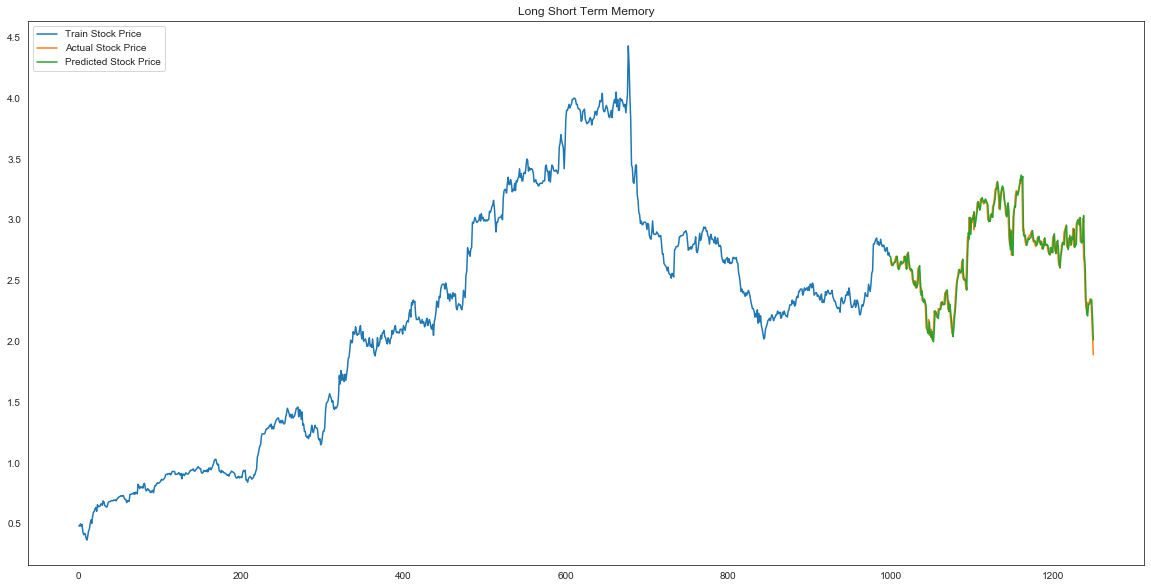

In [523]:
stockDAMACY_test['PredClose'] = preds
plt.figure(figsize=(20,10))
plt.plot(stockDAMACY_train['Close'], label = "Train Stock Price")
plt.plot(stockDAMACY_test['Close'], label = "Actual Stock Price")
plt.plot(stockDAMACY_test['PredClose'], label = "Predicted Stock Price")
plt.title("Long Short Term Memory")
plt.legend(loc='upper left')
plt.show()

In [690]:
# Print the Root Mean Squared Error (RMSE) of the Long Short Term Memory 
print("Root Mean Squared Error (RMSE):",np.sqrt(np.mean(np.power((stockDAMACY_test['Close']-stockDAMACY_test['PredClose']),2))))

Root Mean Squared Error (RMSE): 0.10587144475162406


<table width="100%" >
  <tr>
    <td><div align="center"></div></td>
    <td><div align="center"><strong>Long Short Term Memory (Original)</strong></div></td>
    <td><div align="center"><strong>Long Short Term Memory (After Tuning)</strong></div></td>
  </tr>
  <tr>
    <td><div align="center"><strong>Root Mean Squared Error (RMSE)</strong></div></td>
    <td><div align="center"><strong>0.15465569016833583</strong></div></td>
    <td><div align="center"><strong>0.0807556613978086</strong></div></td>
  </tr>
  <tr>
    <td><div align="center">epochs</div></td>
    <td><div align="center">1</div></td>
    <td><div align="center">10</div></td>
  </tr>
  <tr>
    <td><div align="center">batch_size</div></td>
    <td><div align="center">1</div></td>
    <td><div align="center">1</div></td>
  </tr>
  <tr>
    <td><div align="center">days in features</div></td>
    <td><div align="center">60</div></td>
    <td><div align="center">30</div></td>
  </tr>
  <tr>
    <td><div align="center">lstm_units</div></td>
    <td><div align="center">50</div></td>
    <td><div align="center">50</div></td>
  </tr>
  <tr>
    <td><div align="center">dropout</div></td>
    <td><div align="center">0.5</div></td>
    <td><div align="center">1</div></td>
  </tr>
</table>

The LSTM network, with its process of sequencing and inbuilt mechanism to regulate the flow of information, is able to produce a significantly better performance with the tuned parameters. The RMSE is far lower than the linear regression at predicting the DAMAC stock close price. However, with the incredible output, it is worth noting that there are other significant factors that affect the movement of stock prices such as news and economic situation.